In [1]:
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt
import xarray as xr
from global_land_mask import globe

import scipy.stats as stats

pplt.rc.update(fontsize=14)
pplt.rc['savefig.dpi'] = 300


In [2]:
# regionLabels = ['Gulf Stream','Kuroshio-Oyashio','Agulhas','Brazil-Malvinas','East Australian']
regionLabels = ['Gulf Stream', 'Kuroshio-Oyashio', 'Agulhas', 'Brazil-Malvinas']
# Define region of interest
region = [None,None,None,None,None] 
region[0] = {'lats': 19,  'latn': 58,  'lonw': 268,   'lone': 344}     # Gulf stream
region[1] = {'lats': 20,  'latn': 55,  'lonw': 119,   'lone': 215}     # Kuroshio-Oyashio Extension
region[2] = {'lats': -56, 'latn': -23, 'lonw': 2,     'lone':  92}     # Agulhas
region[3] = {'lats': -60, 'latn': -24, 'lonw': 284.9, 'lone': 350}     # Malvinas
region[4] = {'lats': -50, 'latn': -20, 'lonw': 140,   'lone': 170}     # East Australian Current

# Define region of interest
regionInd = [None,None,None,None,None]
regionInd[0] = {'lats': 35,  'latn':45,  'lonw':280, 'lone':310}     # Gulf stream
regionInd[1] = {'lats': 31,  'latn':45,  'lonw':140, 'lone':170}     # Kuroshio-Oyashio Extension
regionInd[2] = {'lats': -45, 'latn':-35, 'lonw':11,  'lone':60 }     # Agulhas
regionInd[3] = {'lats': -50, 'latn':-35, 'lonw':305, 'lone':320}     # Malvinas
regionInd[4] = {'lats': -40, 'latn':-31, 'lonw':147, 'lone':160}     # East Australian Current


def plot_it(loc, data, lvls, region, cmap='Fire', latlabels='l', lonlabels='b', latlonlocatorBool=False, 
            proj='aeqd', colorbar=False, colorbar_kw=False):

    if lvls.any() == False:
        ax = fig.subplot(loc, proj=proj, coast=True, labels=True, lonlabels='b', latlabels='l',
                         latlines=10, lonlines=20,
                         gridminor=True, latminorlines=5, lonminorlines=10,
                         lonlim=(region['lonw']+5, region['lone']-5), latlim=(region['lats']+5, region['latn']-5),
                         proj_kw={'central_longitude': (region['lonw']+region['lone'])/2},
                         )

        m = ax.contourf(data['lon'], data['lat'], data, robust=True, extend='both', 
                        colorbar='b', cmap=cmap, colorbar_kw=colorbar_kw)

    else:
        ax = fig.subplot(loc, proj=proj, coast=True, labels=True, lonlabels=lonlabels, latlabels=latlabels,
                         latlines=10, lonlines=20, land=True, landcolor='white',
                         gridminor=True, latminorlines=5, lonminorlines=10, 
                         lonlim=(region['lonw']+5, region['lone']-5), latlim=(region['lats']+5, region['latn']-5), 
                         proj_kw={'central_longitude': (region['lonw']+region['lone'])/2},
                         )

        m = ax.contourf(data['lon'], data['lat'], data, levels=lvls, extend='both', 
                        cmap=cmap, colorbar=colorbar, colorbar_kw=colorbar_kw)

    return m, ax


def plot_it_pcolor(loc, data, lvls, region, cmap='Fire', latlabels='l', lonlabels='b', latlonlocatorBool=False, proj='aeqd'):

    if lvls.any() == False:
        ax = fig.subplot(loc, proj=proj, coast=True, labels=True, lonlabels='b', latlabels='l',
                         latlines=10, lonlines=20,
                         gridminor=True, latminorlines=5, lonminorlines=10, 
                         lonlim=(region['lonw']+5, region['lone']-5), latlim=(region['lats']+5, region['latn']-5), 
                         proj_kw={'central_longitude': (region['lonw']+region['lone'])/2})

        m = ax.pcolormesh(data['lon'], data['lat'], data, robust=True, extend='both',
                          colorbar='b', cmap=cmap)

    else:
        ax = fig.subplot(loc, proj=proj, coast=True, labels=True, lonlabels=lonlabels, latlabels=latlabels,
                         latlines=10, lonlines=20,
                         gridminor=True, latminorlines=5, lonminorlines=10, 
                         lonlim=(region['lonw']+5, region['lone']-5), latlim=(region['lats']+5, region['latn']-5), 
                         proj_kw={'central_longitude': (region['lonw']+region['lone'])/2},
                         )

        m = ax.pcolormesh(data['lon'], data['lat'], data, levels=lvls, extend='both',
                          cmap=cmap)

    return m, ax


def stand(da):
    return (da-da.mean('time'))/da.std('time')


def lag_linregress_3D(x, y, lagx=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept
    """ 
    # Citation
    # http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html

    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time=-lagx)[:-lagx]
        # Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x, y = xr.align(x, y)

    # 3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = np.shape(x)[0]
    xmean = np.mean(x, axis=0)
    ymean = np.mean(y, axis=0)
    xstd  = np.std(x, axis=0)
    ystd  = np.std(y, axis=0)

    #4. Compute covariance along time axis
    cov   = np.sum((x - xmean)*(y - ymean), axis=0)/n

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope


    return cov, cor, slope, intercept


def land_mask(da):
    data = da[0].copy(deep=True)
    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    lon_grid, lat_grid = np.meshgrid(data['lon'], data['lat'])
    return globe.is_ocean(lat_grid, lon_grid)



# Means of the various fields

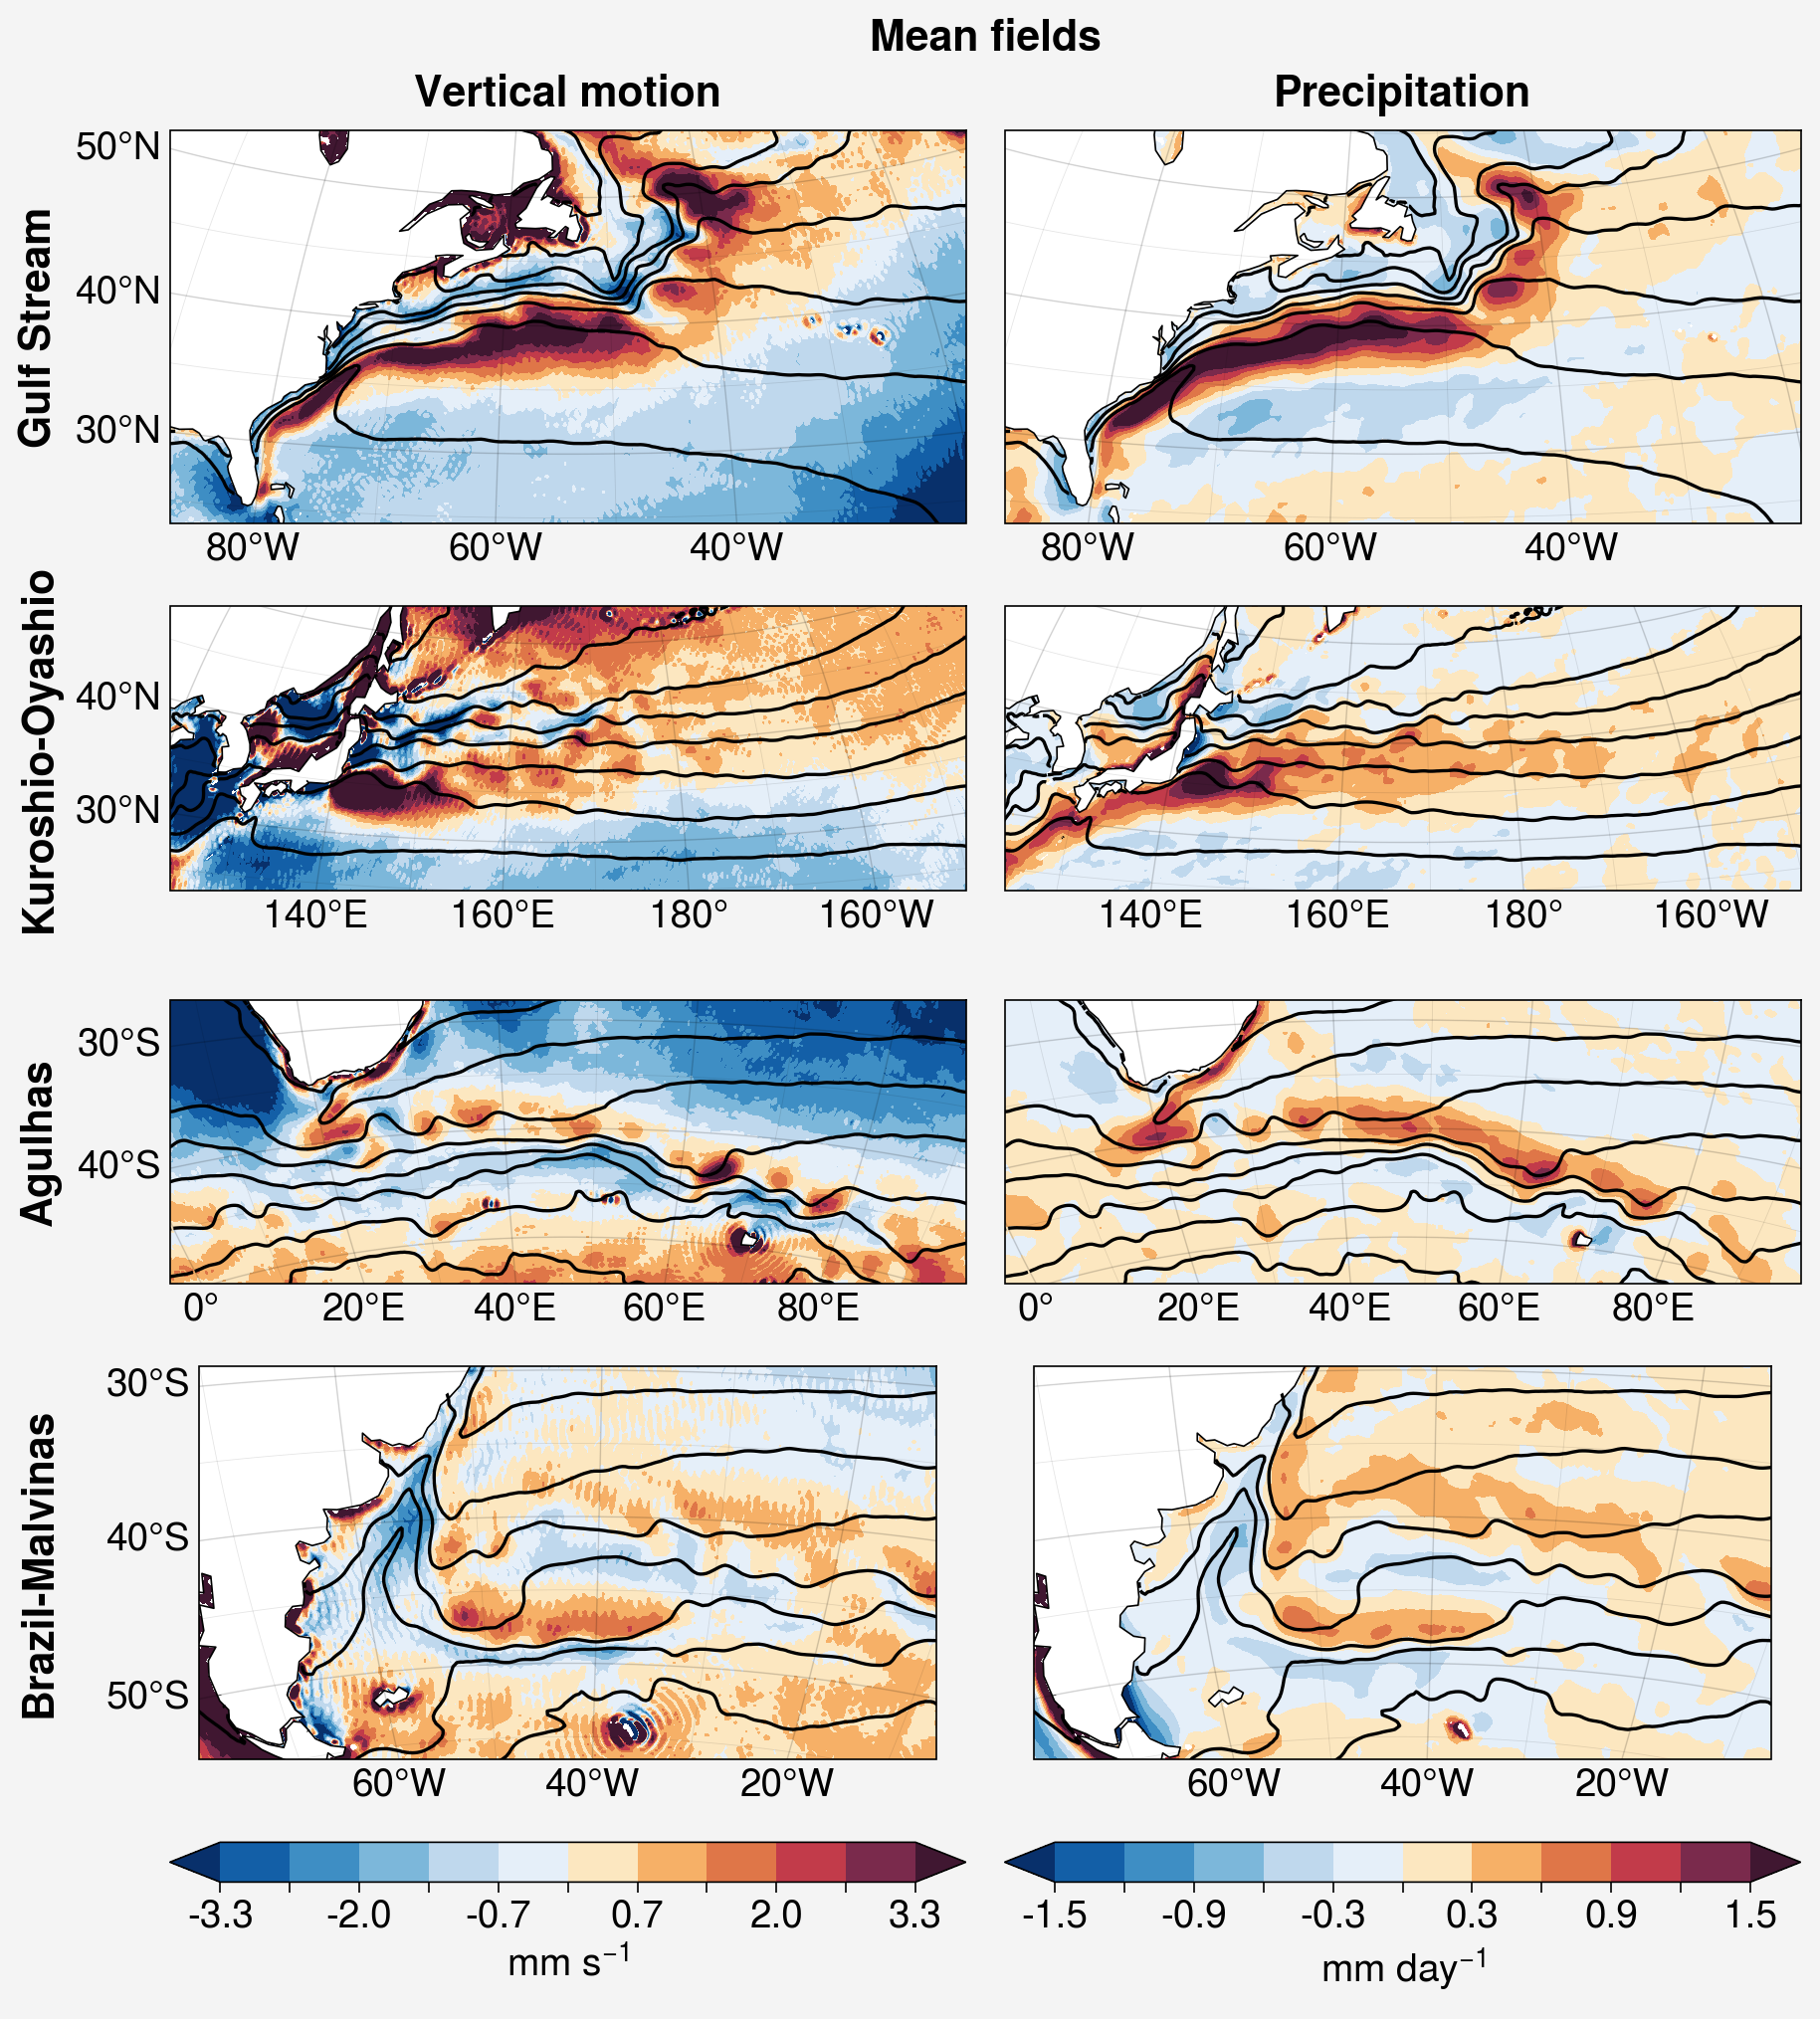

In [4]:
gs = pplt.GridSpec(ncols=2, nrows=4)
fig = pplt.figure(refwidth=4, suptitle='Mean fields')
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvlsSST   = np.arange(275, 275.1+7*3, 3)
lvlsW     = np.arange(-3.3, -3.3+11*0.66, 0.66)
lvlsPrect = np.linspace(-1.5, 1.5, 11)

for ii, val in enumerate(regionLabels):
# for ii, val in enumerate([1]):

    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]


    path = '/glade/work/jamesl/ERA5/'
    SSTE5 = xr.open_dataset(path+'ERA5.h0.SST.197901-202309.nc'
                            )['SST'].sel(time=dateE,
                                         # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                         lat=slice(region[ii]['lats'], region[ii]['latn'])).load()

    wE5 = xr.open_dataset(path+'ERA5.h0.w.200701-202309.nc'
                          )['w'].sel(time=dateE, level=850,
                                     # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                     lat=slice(region[ii]['lats'], region[ii]['latn'])
                                     ).load()*1000

    prectE5 = xr.open_dataset(path+'ERA5.h0.PRECT.1000kmHighPassFiltered.197901-202309.nc'
                              )['PRECT'].sel(time=dateE,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])
                                             ).load()
    SSTE5   = SSTE5.where(  land_mask(SSTE5))
    wE5     = wE5.where(    land_mask(wE5))
    prectE5 = prectE5.where(land_mask(prectE5))

    data  = SSTE5[    SSTE5['time.month'].isin(months)].mean('time')
    data1 = wE5[        wE5['time.month'].isin(months)].mean('time')
    data2 = prectE5[prectE5['time.month'].isin(months)].mean('time')

    n, ax = plot_it(gs[ii, 0], data1, lvlsW, region[ii], cmap=cmap1)
    ax.contour(data['lon'], data['lat'], data, levels=lvlsSST, extend='both', c='k', lw=1.2)
    ax.format(land=True, landcolor='white')

    o, ax = plot_it(gs[ii, 1], data2, lvlsPrect, region[ii], cmap=cmap1,
                    latlabels=False)
    ax.contour(data['lon'], data['lat'], data, levels=lvlsSST, extend='both', c='k', lw=1.2)
    ax.format(land=True, landcolor='white')

fig.format(rowlabels=regionLabels,
           collabels=['Vertical motion', 'Precipitation'])

# fig.colorbar(m, loc='b', label='K',             col=1, ticklabelsize='large', labelsize='x-large')

tlabels = [str(np.round(val, decimals=1)) for val in lvlsW]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm s$^{-1}$',   col=1, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=2)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(o, loc='b', label='mm day$^{-1}$', col=2, ticklabels=tlabels)

fig.save('meanFieldOfSST_w850_PRECT-ERA5-LarsonThompsonHurrell2024.png')
fig.save('meanFieldOfSST_w850_PRECT-ERA5-LarsonThompsonHurrell2024.pdf')


# σ of Anomalous SST, ω$_{850}$, and HP Filtered Precipitation & Regression of ω850 and PRECIP - ERA5

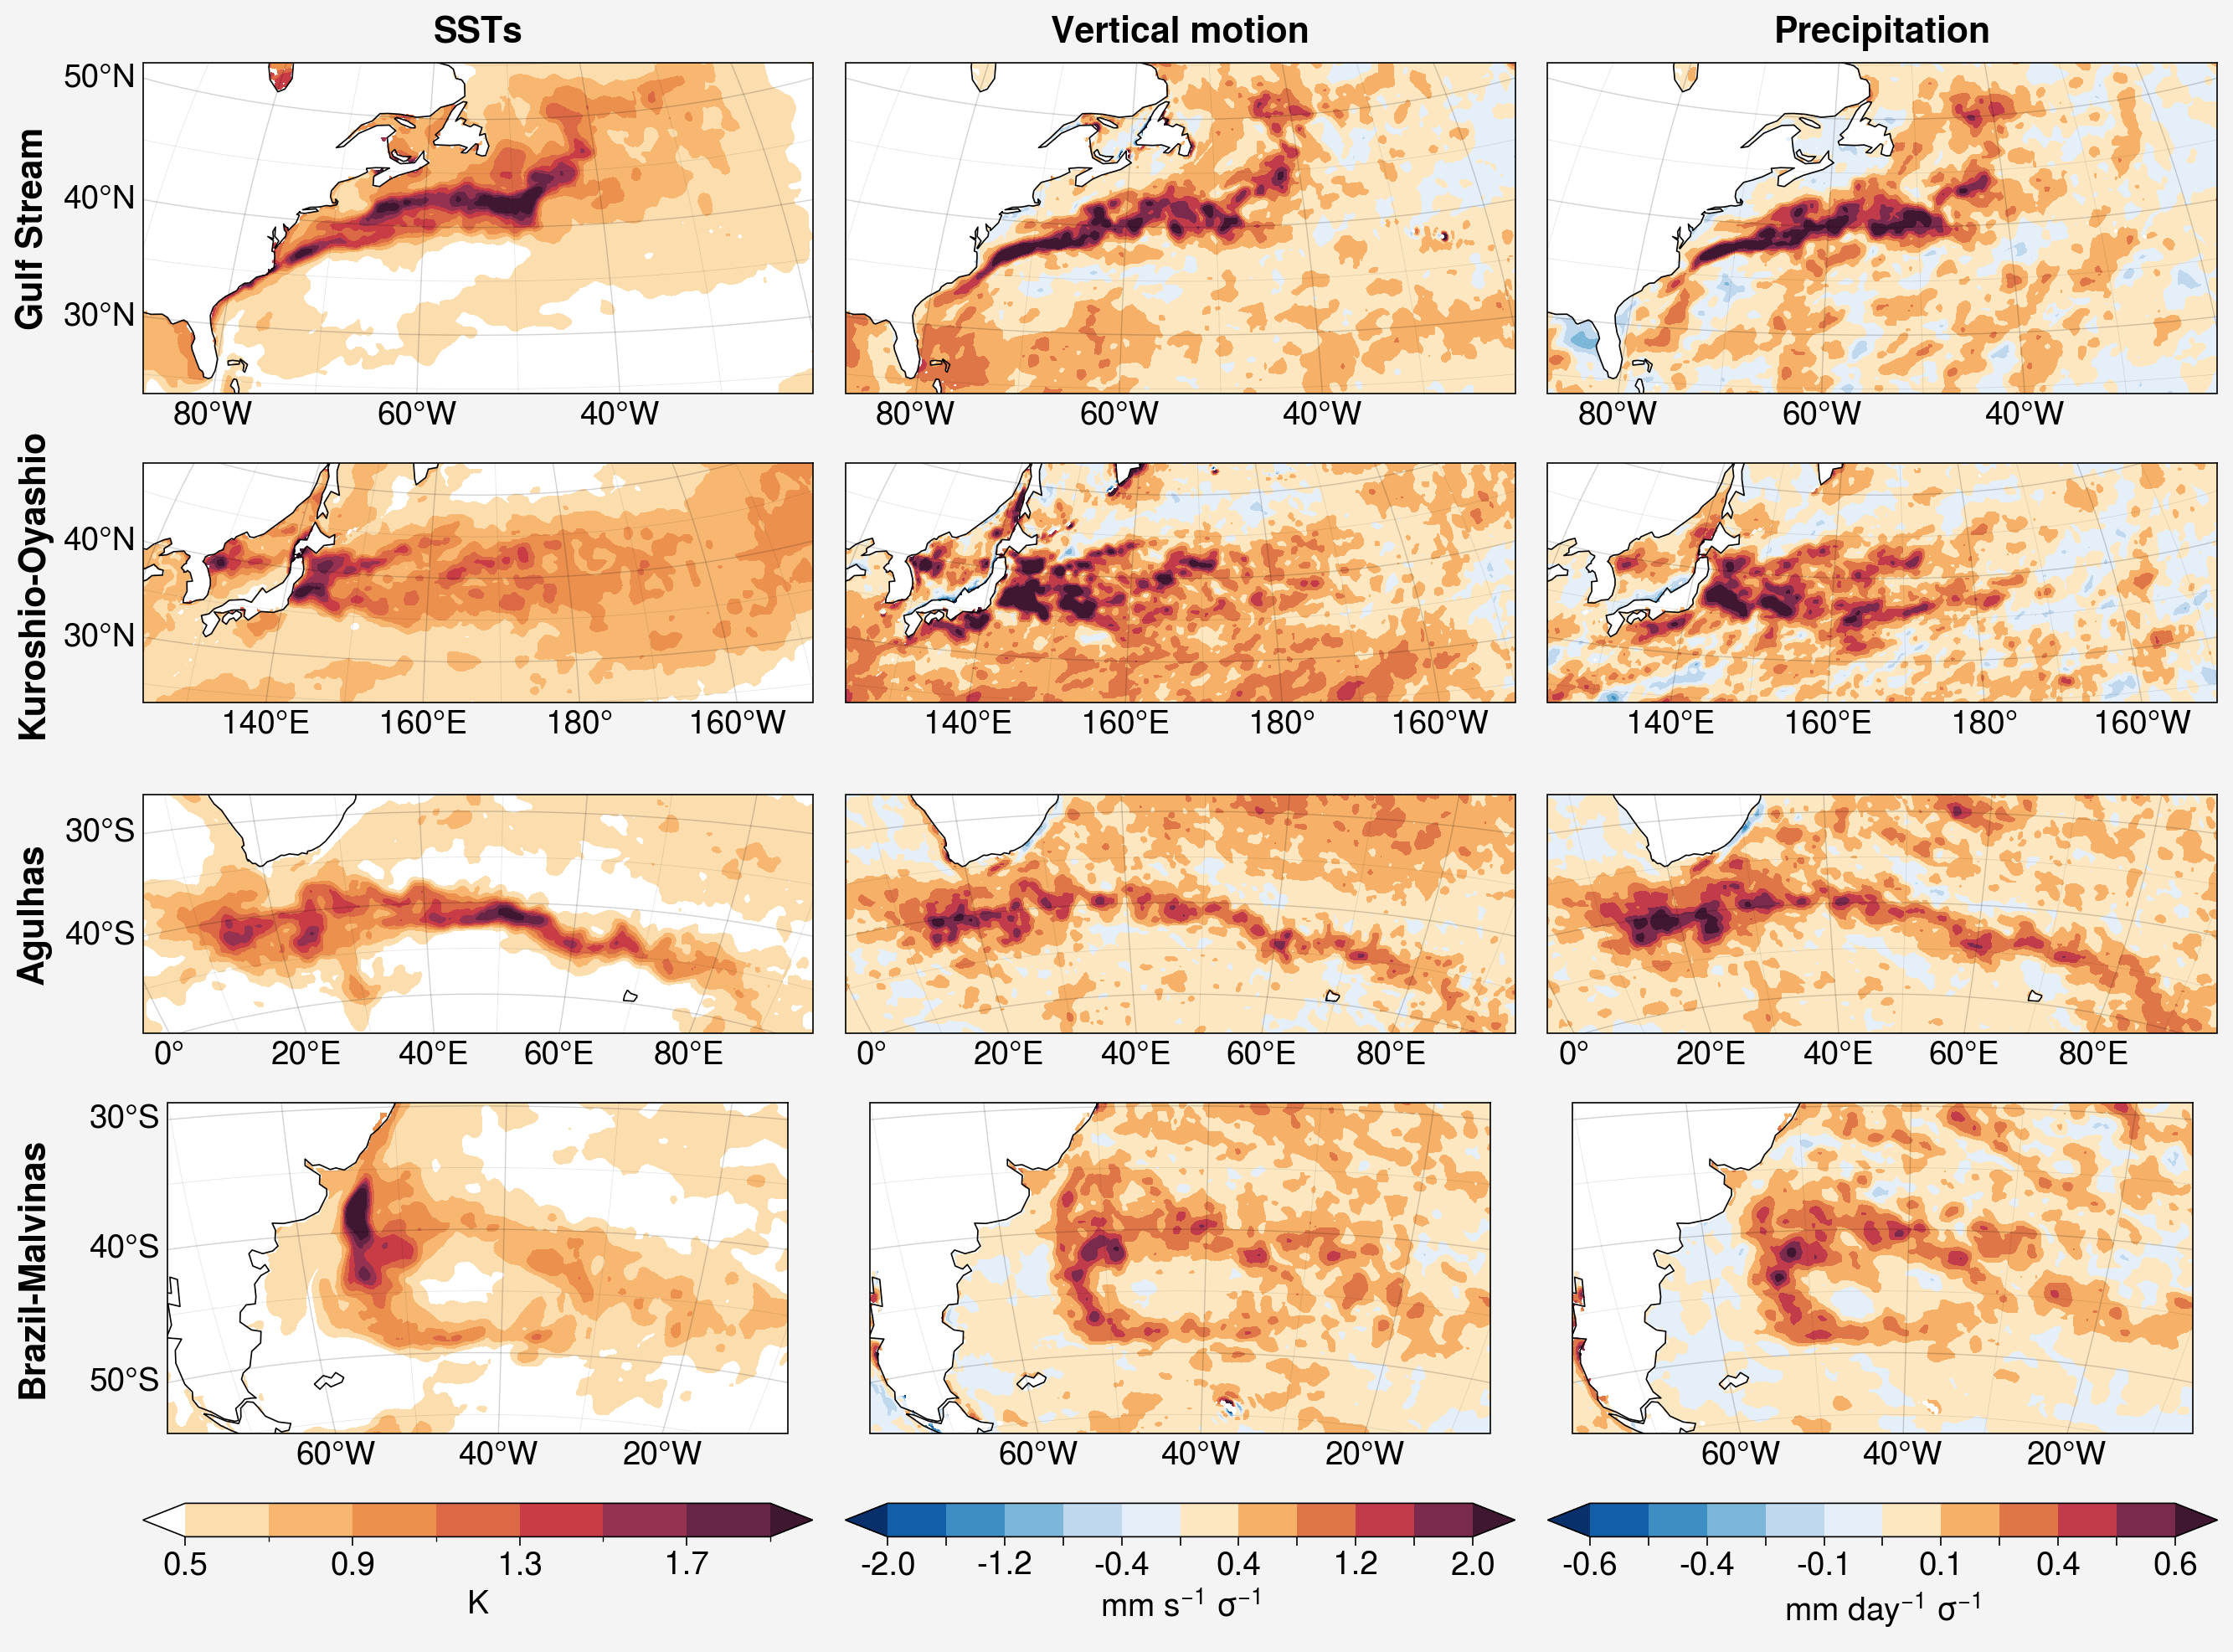

In [4]:
gs = pplt.GridSpec(ncols=3, nrows=4)
fig = pplt.figure(refwidth=4)
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvlsSST   = np.arange(0.5, 1.91, 0.2)
lvlsOmega = np.arange(-2,2.1,0.4)
lvlsPrect = np.arange(-0.625, 0.6251, 0.125)

for ii, val in enumerate(regionLabels):
    
    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        dateG = slice('2006-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        dateG = slice('2006-04', '2022-09')
        months = [4, 5, 6, 7, 8, 9]


    path = '/glade/work/jamesl/ERA5/'
    SSTE5anom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                                )['SST'].sel(time=dateE,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])
                                             ).load()
    SSTE5anom = SSTE5anom.where(land_mask(SSTE5anom))

    prectE5anom = xr.open_dataset(path+'ERA5.h0.PRECT.anomalies.41HPfilter.197901-202309.nc'
                                  )['PRECT'].sel(time=dateE,
                                                 # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                 lat=slice(region[ii]['lats'], region[ii]['latn'])).load()

    wE5anom = xr.open_dataset(path+'ERA5.h0.w.anomalies.200701-202309.nc'
                              )['w'].sel(time=dateE, level=850,
                                         # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                         lat=slice(region[ii]['lats'], region[ii]['latn'])
                                         ).load()*1000

    prectE5anomRegWinter = prectE5anom[0].copy(deep=True)
    wE5anomRegWinter = wE5anom[0].copy(deep=True)

    data  = prectE5anom[prectE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    prectE5anomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data  = wE5anom[wE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    wE5anomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data = SSTE5anom[SSTE5anom[ 'time.month'].isin(months)].std('time')

    l, ax = plot_it(gs[ii, 0], data,                 lvlsSST,   region[ii])
    m, ax = plot_it(gs[ii, 1], wE5anomRegWinter,     lvlsOmega, region[ii], cmap=cmap1, latlabels=False)
    n, ax = plot_it(gs[ii, 2], prectE5anomRegWinter, lvlsPrect, region[ii], cmap=cmap1, latlabels=False)


fig.format(rowlabels=regionLabels,
           collabels=['SSTs', 'Vertical motion', 'Precipitation'])

fig.colorbar(l, loc='b', label='K', col=1)

tlabels = [str(np.round(val, decimals=3)) for val in lvlsOmega]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(m, loc='b', label='mm s$^{-1}$ σ$^{-1}$',   col=2, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm day$^{-1}$ σ$^{-1}$', col=3, ticklabels=tlabels)

fig.save('stdDevOfAnomalousSST_regressonOfw850_PRECT-ERA5-LarsonThompsonHurrell2024.png')
fig.save('stdDevOfAnomalousSST_regressonOfw850_PRECT-ERA5-LarsonThompsonHurrell2024.pdf')



# Vertical Profile of ω regression

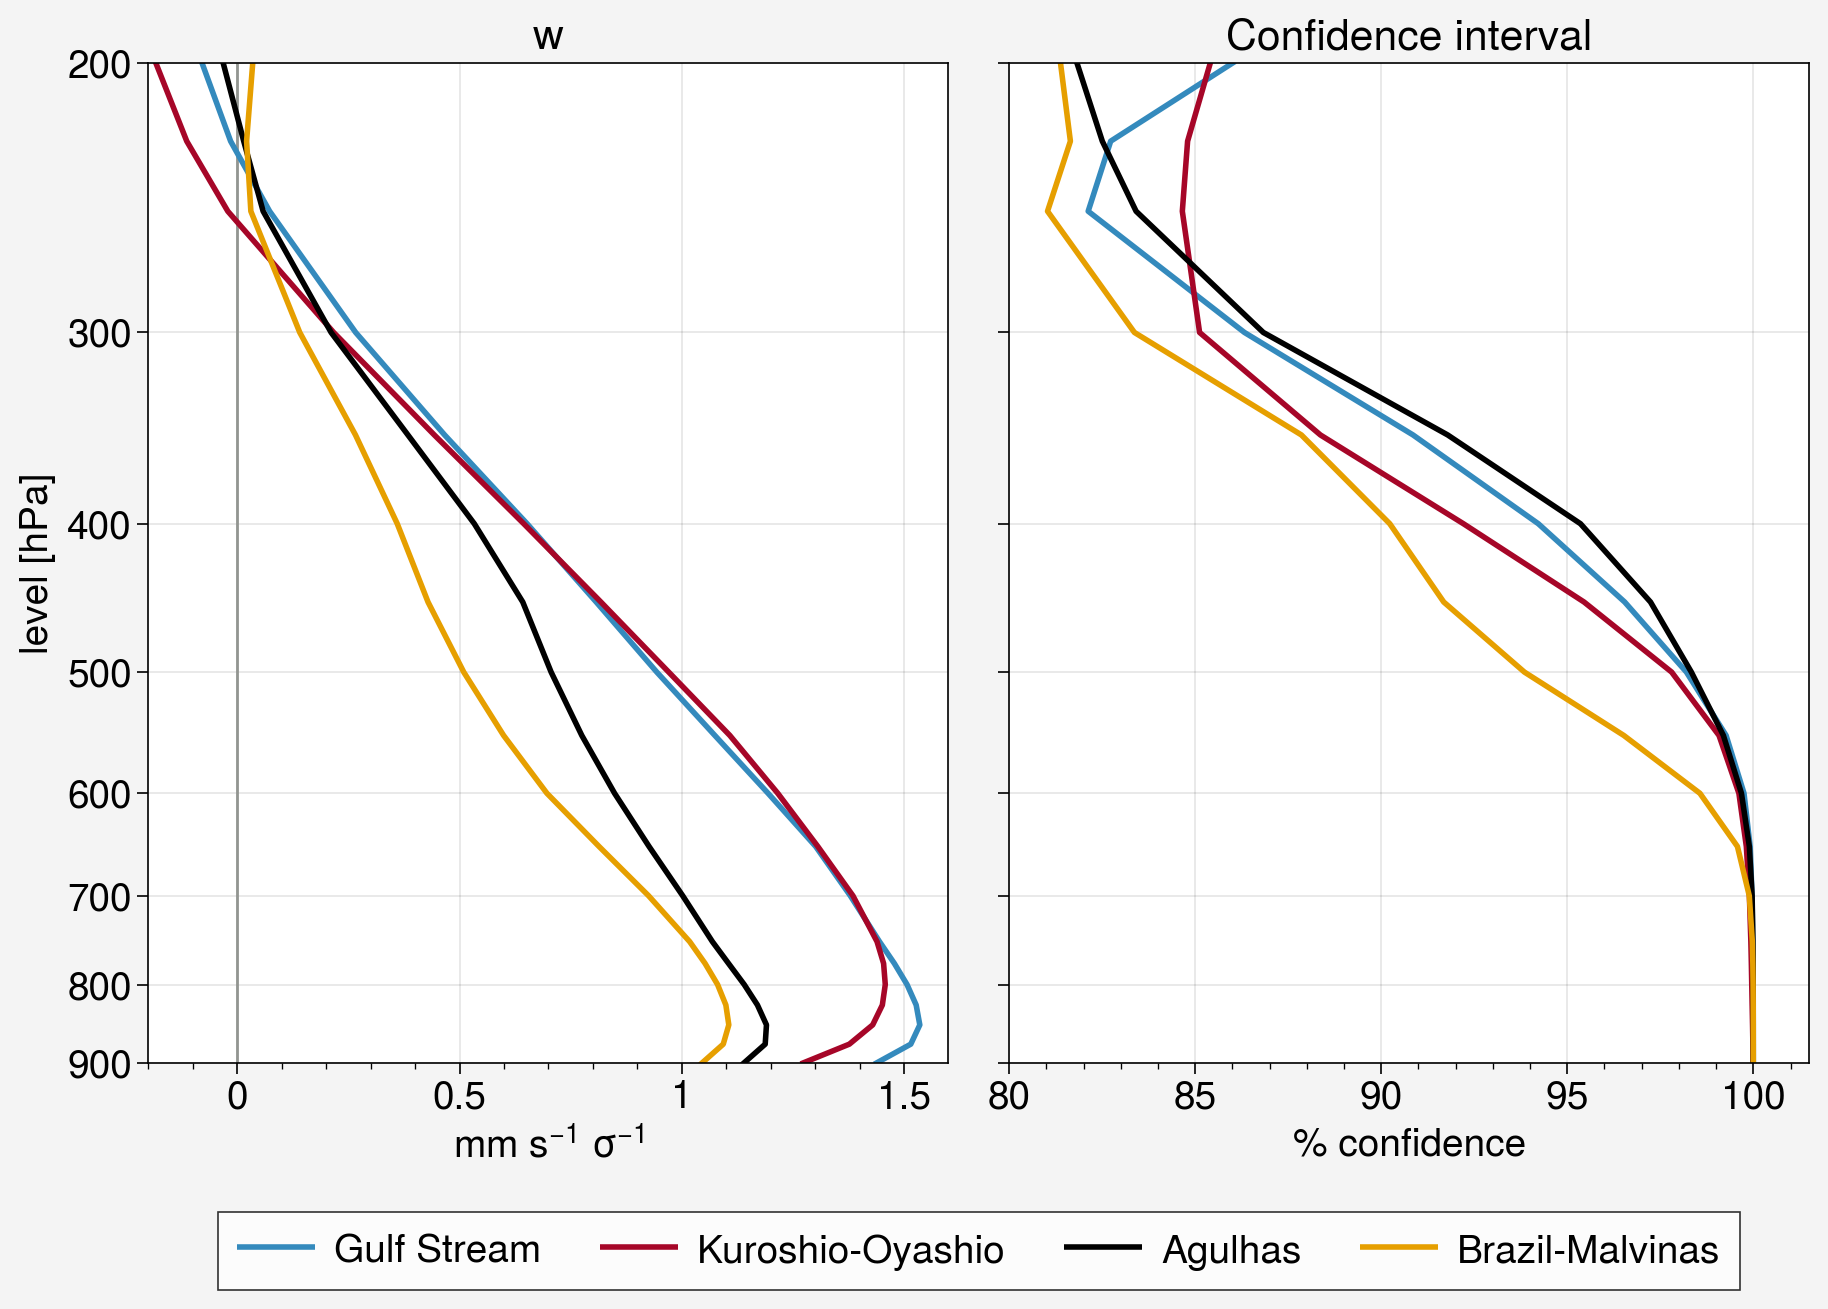

In [9]:
fig = pplt.figure(refwidth=4, refaspect=0.8, sharex=False) #,
                  # suptitle='Regression of vertical motion onto SST as a function of height')
axs = fig.subplots(ncols=2, yreverse=True, yscale='log', yticks=True, ylabel='level [hPa]')

# 15 seasons of data, 3 months of independent samples per season
dof = 88

# Calculate the upper t value for significance testing
tStatUp99 = stats.t.ppf(.99, loc=0, scale=1, df=dof)
tStatUp90 = stats.t.ppf(.90, loc=0, scale=1, df=dof)

# Plot vertical lines at 0
axs[0].vlines(0, 200, 900, c='grey', lw=1)
axs[1].vlines(0, 200, 900, c='grey', lw=1)

# # Colors gotten from pplt.Cycle('bmh')
# bmhColors = ['#348abdff', '#a60628ff', '#467821ff', '#d55e00ff', '#cc79a7ff',
#              '#56b4e9ff', '#009e73ff', '#f0e442ff', '#0072b2ff']
colors = ['#348abdff', '#a60628ff', 'k', '#E69F00']
# bmhColors = ['#348abdff', '#a60628ff', '#7a68a6ff', '#467821ff', '#d55e00ff', '#cc79a7ff', 
#              '#56b4e9ff', '#009e73ff', '#f0e442ff', '#0072b2ff']

for ii, iiVal in enumerate(regionLabels):

    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]

    path = '/glade/work/jamesl/ERA5/'
    SSTE5anom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                                )['SST'].sel(time=dateE,
                                             lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                                             lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])).load()

    wE5anom = xr.open_dataset(path+'ERA5.h0.w.anomalies.200701-202309.nc'
                              )['w'].sel(time=dateE, level=slice(200, 900),
                                         lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                                         lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])
                                         ).load()*1000  # convert to mm/s from m/s

    # omegaE5anom = -xr.open_dataset(path+'ERA5.h0.OMEGA.anomalies.200701-202309.nc'
    #                                )['OMEGA'].sel(time=dateE, level=850,
    #                                               lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
    #                                               lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])).load()

    # data  = omegaE5anom[omegaE5anom['time.month'].isin(months)]
    # data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    # omegaMask = lag_linregress_3D(data1.values, data.values)[2] > 0.008
    data  = wE5anom[wE5anom['time.month'].isin(months)].sel(level=850)
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    wMask = lag_linregress_3D(data1.values, data.values)[2] > 0.8

    # omegaE5anomRegWinter      = omegaE5anom[0, 0].copy(deep=True)
    wE5anomRegWinterTvals = wE5anom[0, 0].copy(deep=True)
    wE5anomRegWinter      = wE5anom[0, 0].copy(deep=True)

    # omegaregressAvg = np.zeros(omegaE5anom['level'].size)
    # omegaTvalsAvg   = np.zeros(omegaE5anom['level'].size)
    wregressAvg     = np.zeros(wE5anom['level'].size)
    wTvalsAvg       = np.zeros(wE5anom['level'].size)

    for zz, levVal in enumerate(wE5anom['level']):

        # data  = omegaE5anom[omegaE5anom['time.month'].isin(months)][:, zz]
        # data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
        # omegaE5anomRegWinterTvals[:, :], omegaE5anomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[1:3]

        data  = wE5anom[wE5anom['time.month'].isin(months)][:, zz]
        data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
        wE5anomRegWinterTvals[:, :], wE5anomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[1:3]

        # Calculate the t statistic
        wE5anomRegWinterTvals = wE5anomRegWinterTvals*np.sqrt(dof-2)/np.sqrt(1-wE5anomRegWinterTvals**2)

        # Calculate area averaged regression values
        # omegaregressAvg[zz] = omegaE5anomRegWinter.where(omegaMask
        #                                                  ).weighted(np.cos(np.deg2rad(omegaE5anomRegWinter.lat))
        #                                                             ).mean(['lat', 'lon']).values
        wregressAvg[zz] = wE5anomRegWinter.where(wMask
                                                 ).weighted(np.cos(np.deg2rad(wE5anomRegWinter.lat))
                                                            ).mean(['lat', 'lon']).values

        # Calculate area averaged t values
        wTvalsAvg[zz] = np.sqrt((wE5anomRegWinterTvals**2
                                     ).where(wMask
                                             ).weighted(np.cos(np.deg2rad(wE5anomRegWinterTvals.lat))
                                                        ).mean(['lat', 'lon'])
                                    )

    axs[0].plot(wregressAvg, wE5anom['level'].values, c=colors[ii], lw=2, label=regionLabels[ii])

    axs[1].plot(stats.t.cdf(wTvalsAvg, loc=0, scale=1, df=dof)*100, wE5anom['level'].values, c=colors[ii], lw=2)

    axs[0].format(xlabel='mm s$^{-1}$ σ$^{-1}$',      xlim=(-0.2, 1.6),
                  title='w')
    axs[1].format(xlabel='% confidence', xlim=(80, 101.5),
                  title='Confidence interval')

fig.legend(loc='b', ncols=4)

fig.save('verticalProfileOfOmegaRegression-88dof-ERA5-alternateColor4-LarsonThompsonHurrell2024a.png')
fig.save('verticalProfileOfOmegaRegression-88dof-ERA5-alternateColor4-LarsonThompsonHurrell2024a.pdf')


# σ of Anomalous SST, ω$_{850}$, and HP Filtered Precipitation & Regression of ω850 and PRECIP - iHESP HR

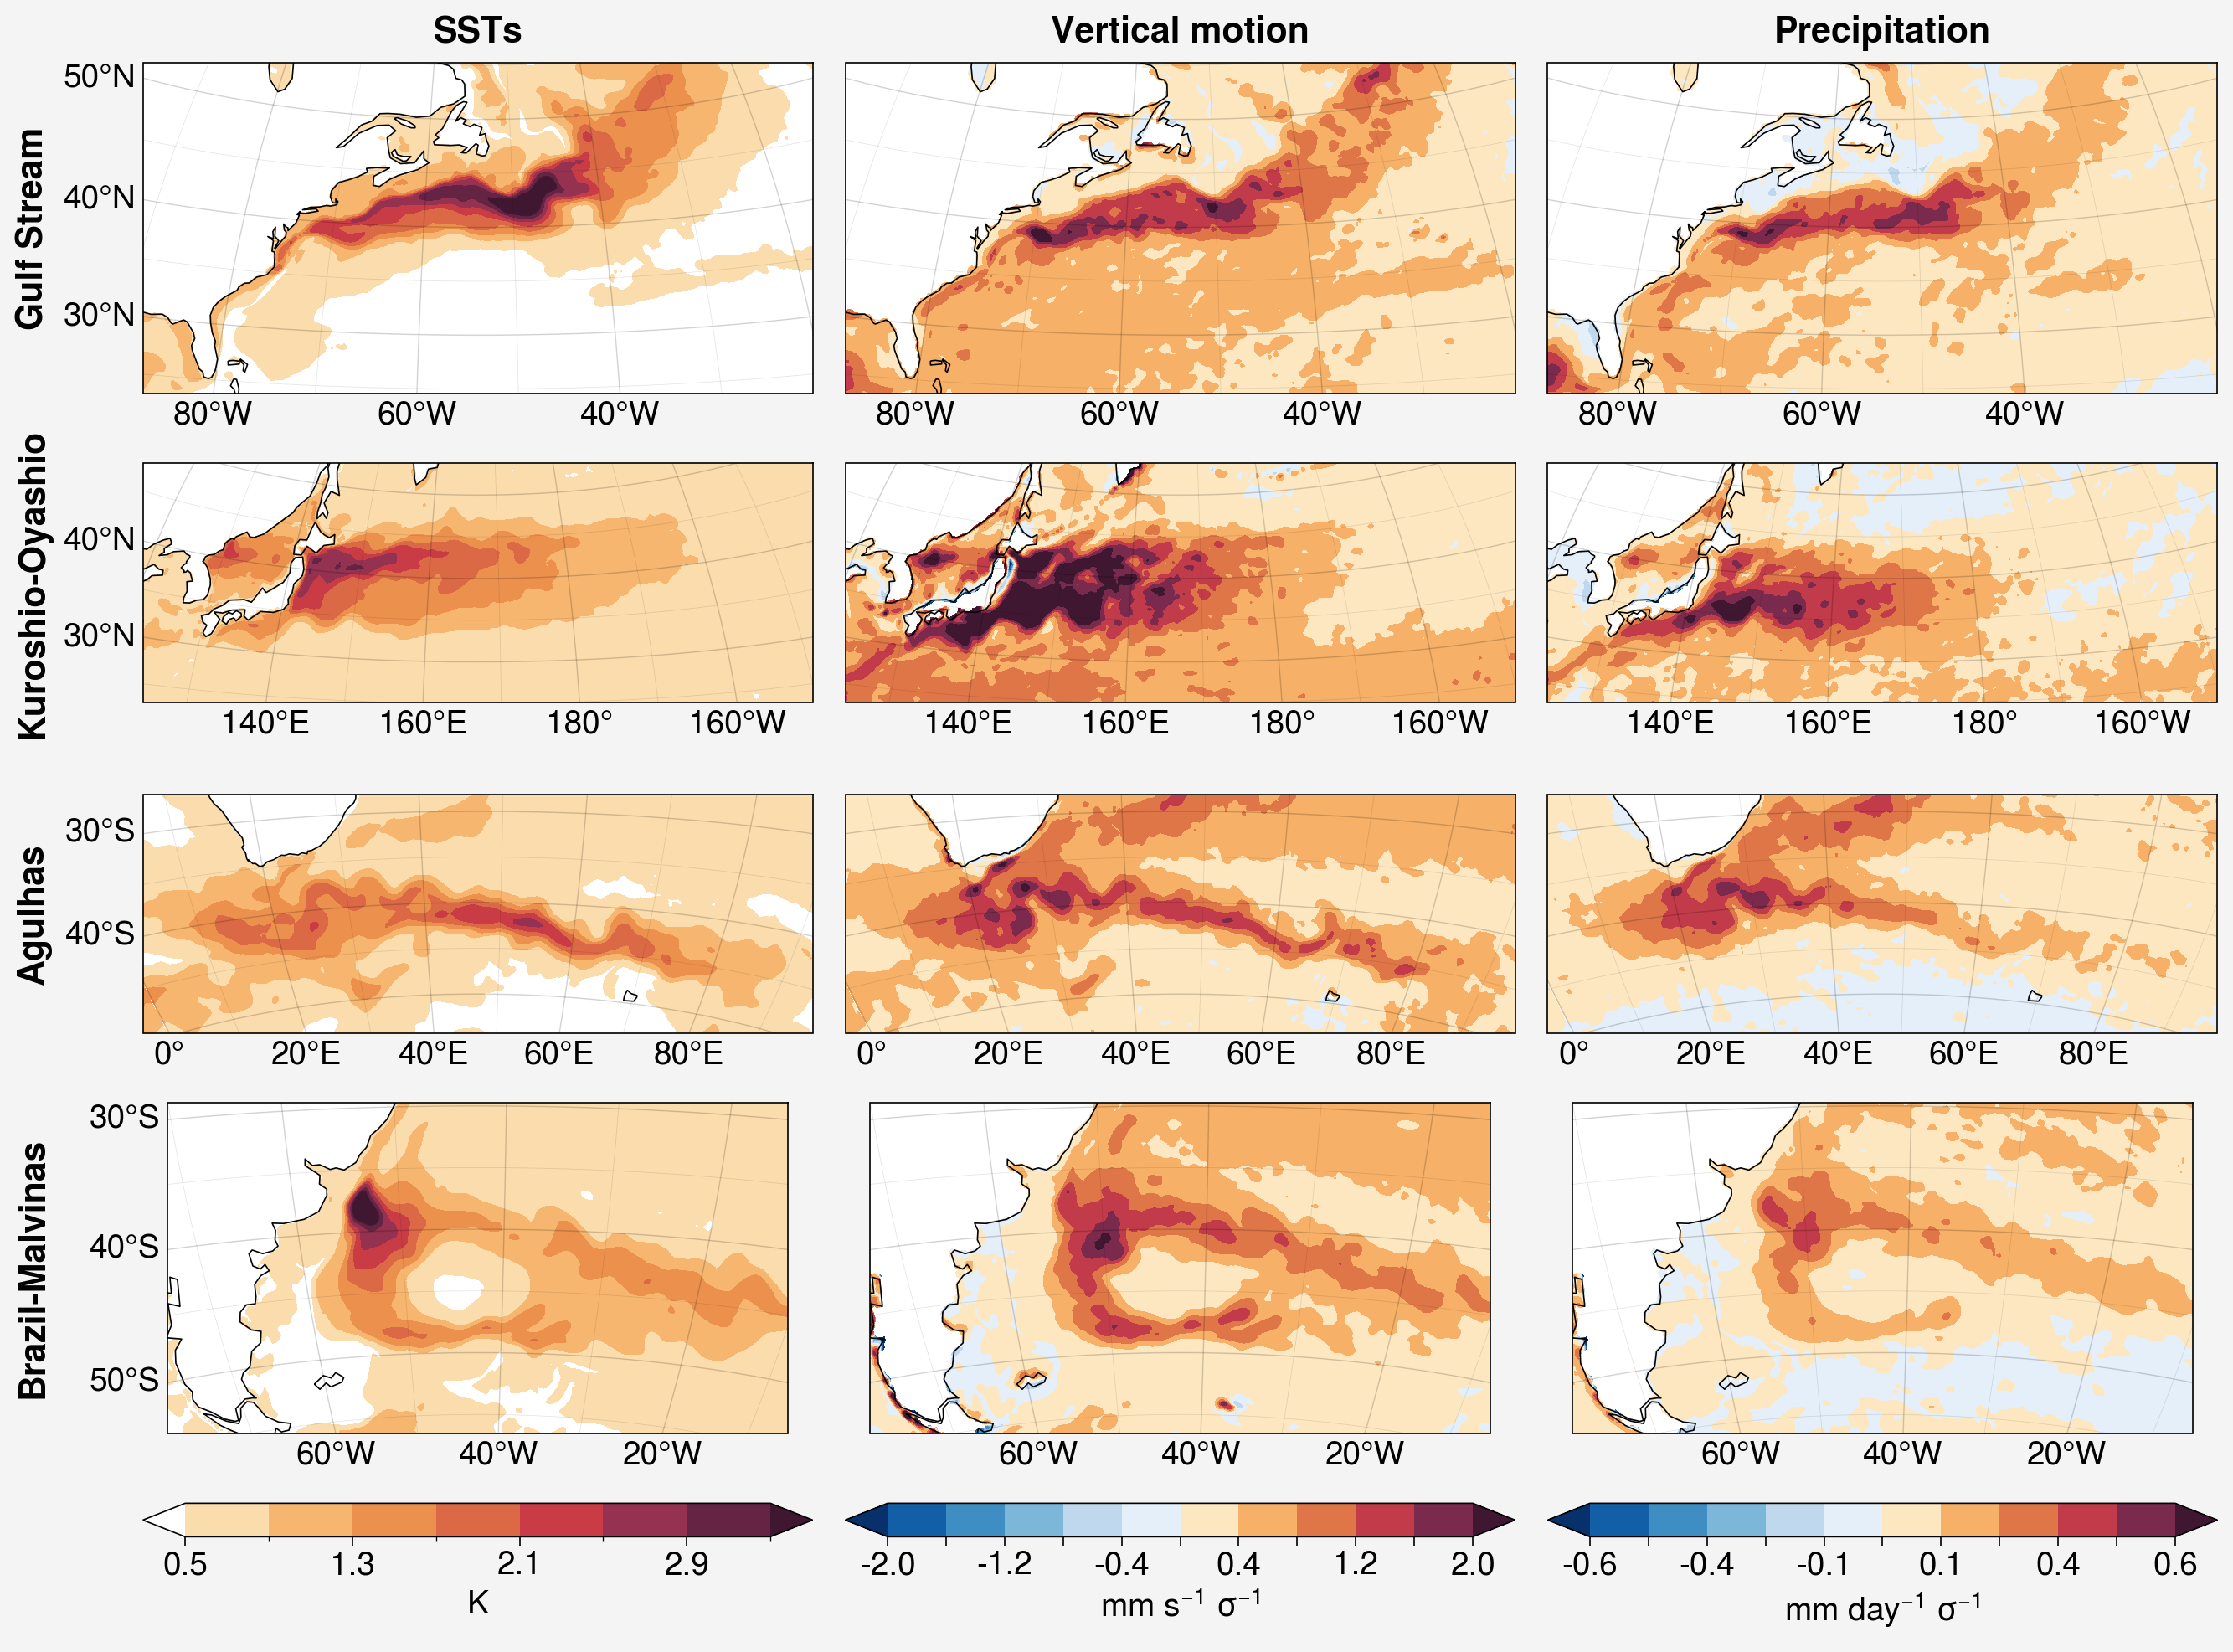

In [6]:
gs = pplt.GridSpec(ncols=3, nrows=4)
fig = pplt.figure(refwidth=4)  #suptitle='Standard deviations of monthly anomalies')

lvlsSST   = np.arange(0.5, 0.51+7*0.4, 0.4)
lvlsW = np.linspace(-2, 2, 11)
lvlsPrect = np.arange(-0.625, 0.6251, 0.125)

for ii, val in enumerate(regionLabels):

    # Load in the data of interest
    if ii < 2:
        months = [10, 11, 12, 1, 2, 3]
        datei = slice('0250-06', '0500-07')
    elif ii >= 2:
        months = [4, 5, 6, 7, 8, 9]
        datei = slice('0250-01', '0500-12')

    path = '/glade/work/jamesl/iHESP/HR/monthly/'
    SSTHRanom = xr.open_dataset(path+'iHESP.HR.PIctrl.h0.SST.anomalies.025001-051912.nc', use_cftime=True
                                )['SST'].sel(time=datei,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])).load()

    wHRanom = xr.open_dataset(path+'iHESP.HR.PIctrl.h0.w.anomalies.025001-051912.nc', use_cftime=True
                              )['w'].sel(time=datei,
                                         # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                         lat=slice(region[ii]['lats'], region[ii]['latn'])
                                         ).load().interp_like(SSTHRanom[0], kwargs={"fill_value": "extrapolate"})*1000 # convert to mm/s

    prectHRanom = xr.open_dataset(path+'iHESP.HR.PIctrl.h0.PRECT.anomalies.41HPfilter.025001-051912.nc', use_cftime=True
                                  )['PRECT'].sel(time=datei,
                                                 # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                 lat=slice(region[ii]['lats'], region[ii]['latn'])
                                                 ).load().interp_like(SSTHRanom[0], kwargs={"fill_value": "extrapolate"})

    data = prectHRanom[0].copy(deep=True)
    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    lon_grid, lat_grid = np.meshgrid(data['lon'], data['lat'])
    landMask = globe.is_ocean(lat_grid, lon_grid)

    wHRanomRegWinter = wHRanom[0].copy(deep=True)
    prectHRanomRegWinter = prectHRanom[0].copy(deep=True)

    data  = wHRanom[wHRanom['time.month'].isin(months)]
    data1 = stand(SSTHRanom[SSTHRanom['time.month'].isin(months)])
    wHRanomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data  = prectHRanom[prectHRanom['time.month'].isin(months)]
    data1 = stand(SSTHRanom[SSTHRanom['time.month'].isin(months)])
    prectHRanomRegWinter[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data = SSTHRanom[SSTHRanom['time.month'].isin(months)].std('time')

    m, ax = plot_it(gs[ii, 0], data,                 lvlsSST,   region[ii])
    n, ax = plot_it(gs[ii, 1], wHRanomRegWinter, lvlsW, region[ii], cmap=cmap1, 
                    latlabels=False)
    o, ax = plot_it(gs[ii, 2], prectHRanomRegWinter, lvlsPrect, region[ii], cmap=cmap1, 
                    latlabels=False)

fig.format(rowlabels=regionLabels,
           collabels=['SSTs', 'Vertical motion', 'Precipitation'])

fig.colorbar(m, loc='b', label='K', col=1)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsW]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm s$^{-1}$ σ$^{-1}$',   col=2, rotation=0, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(o, loc='b', label='mm day$^{-1}$ σ$^{-1}$', col=3, ticklabels=tlabels)

fig.save('stdDevOfAnomalousSST_regressOmega850_PRECTfilt-iHESP-HR-LarsonThompsonHurrell2024a.png')
fig.save('stdDevOfAnomalousSST_regressOmega850_PRECTfilt-iHESP-HR-LarsonThompsonHurrell2024a.pdf')



# Suppl Figure: As in Fig 2 but based on obs (OISST, ERA5, and GPM)

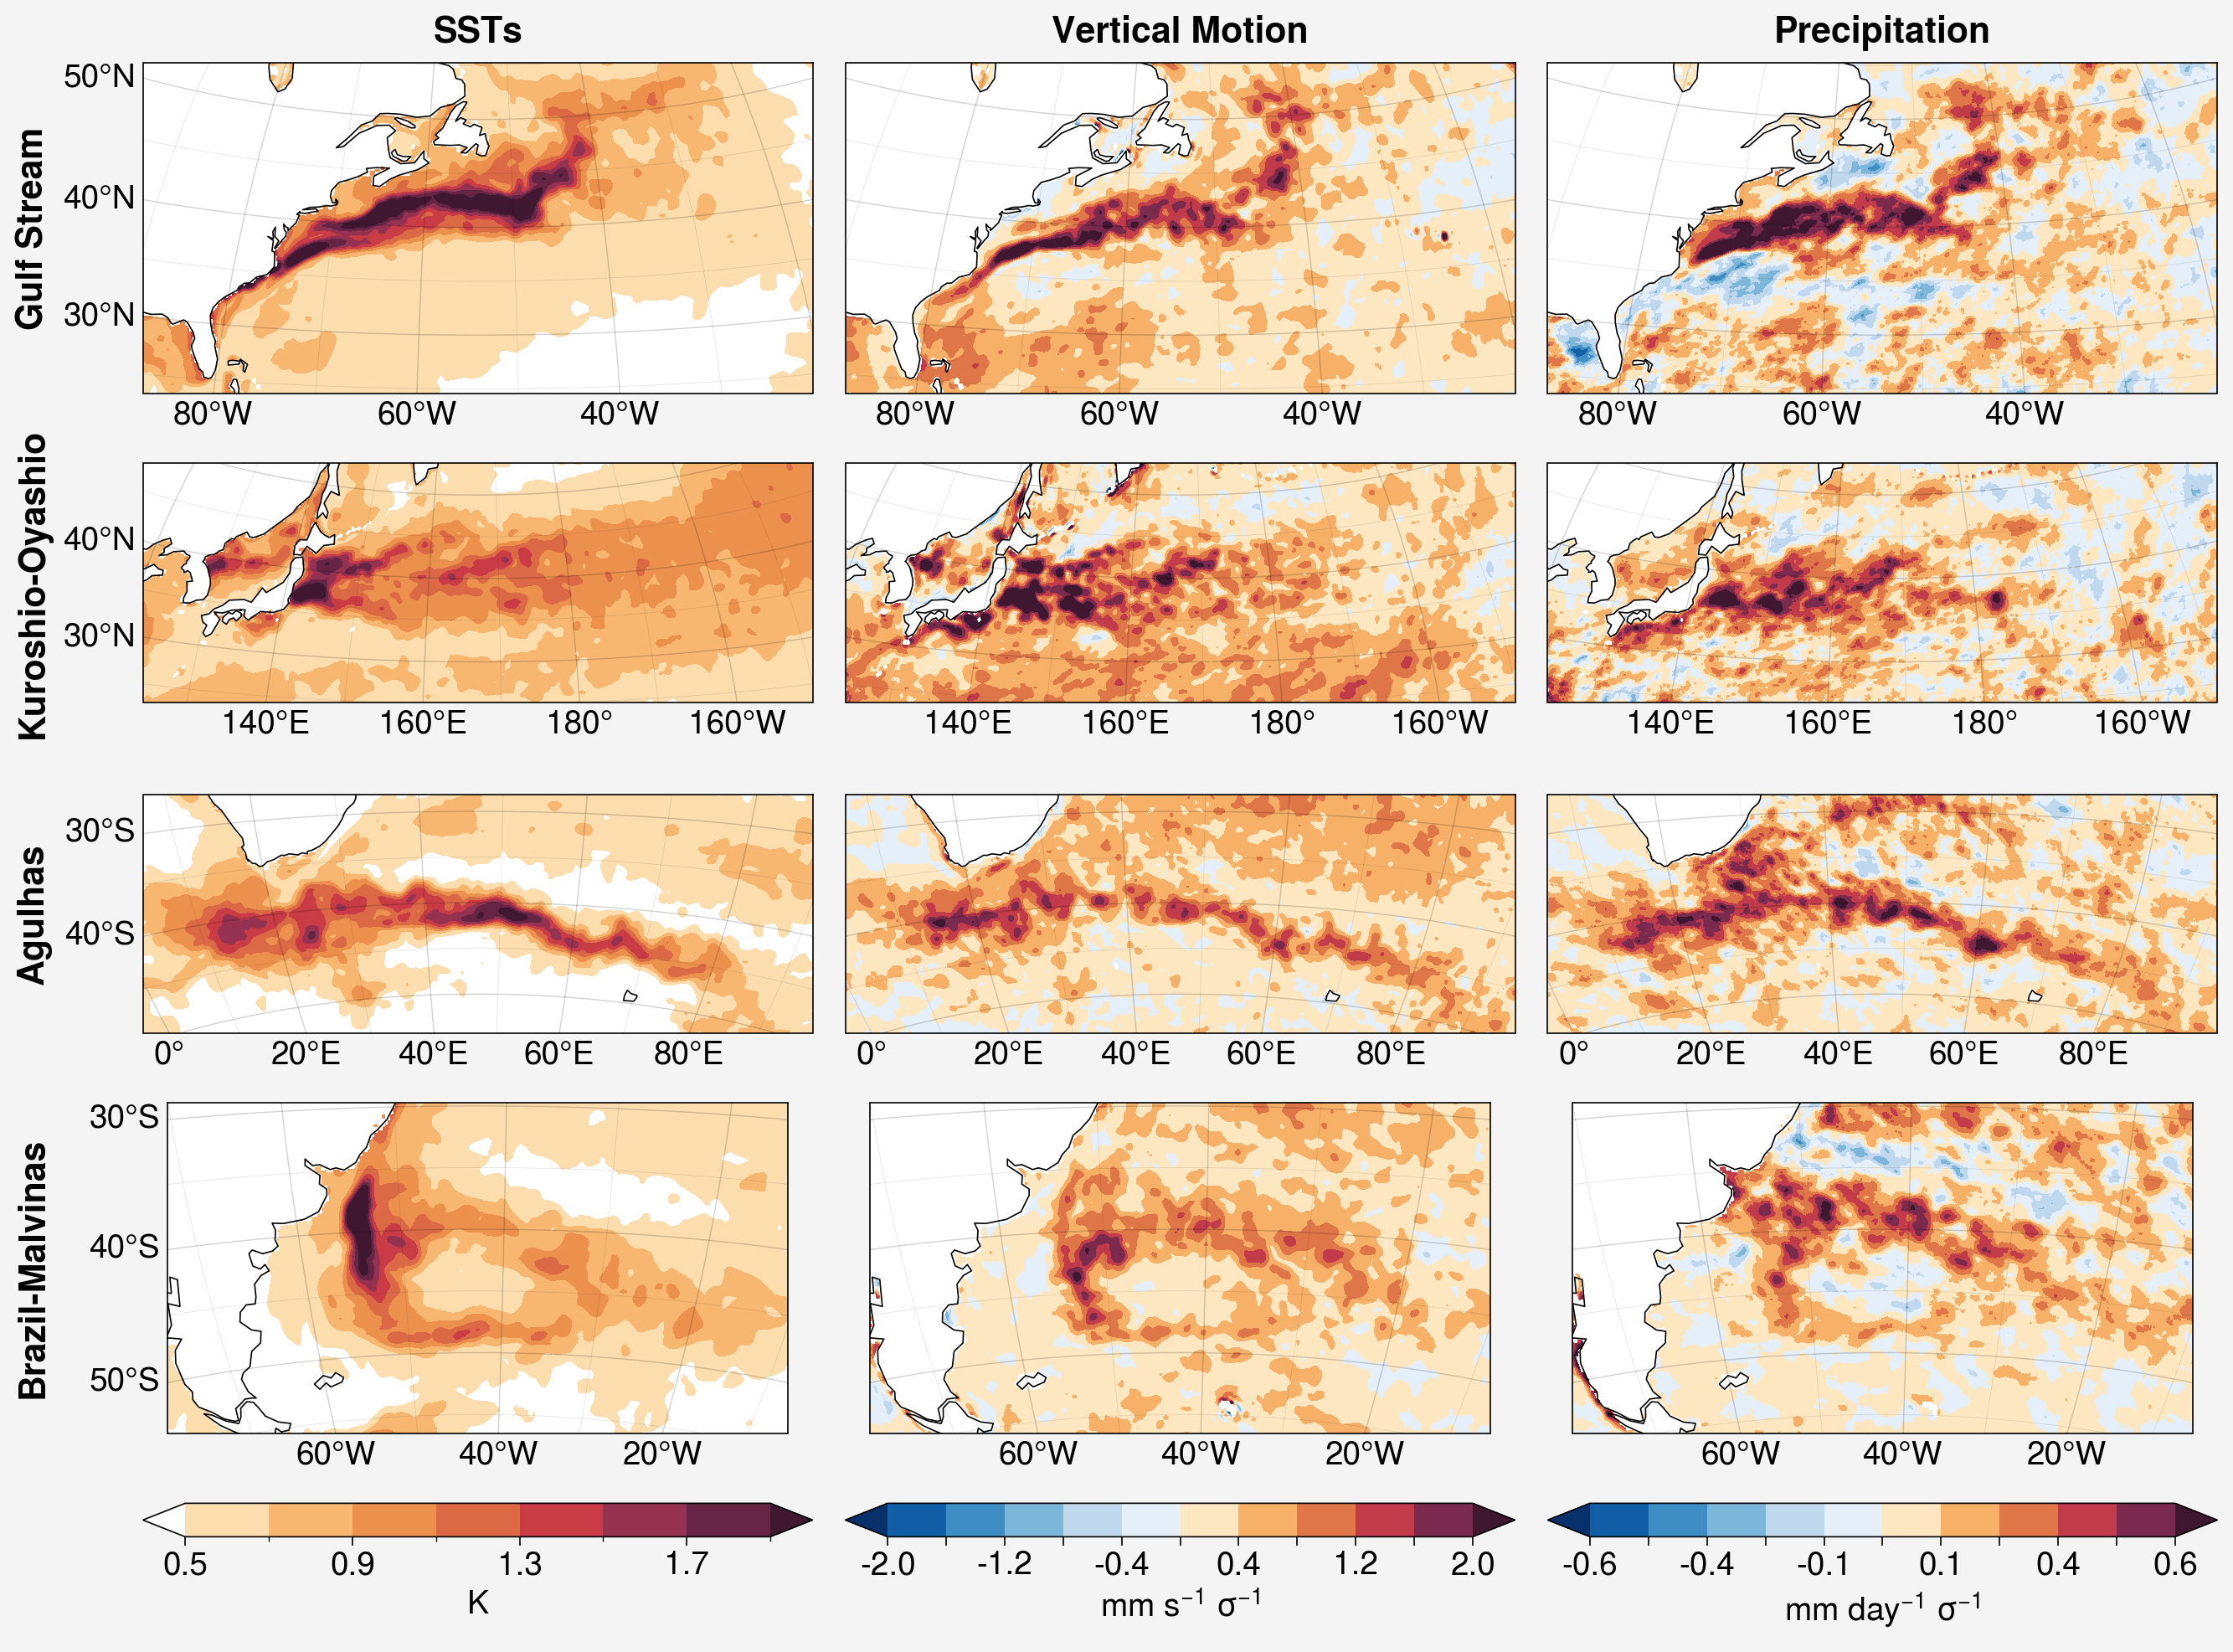

In [12]:
gs = pplt.GridSpec(ncols=3, nrows=4)
fig = pplt.figure(refwidth=4)
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvlsSST   = np.arange(0.5, 1.91, 0.2)
lvlsOmega = np.arange(-2, 2.1, 0.4)
lvlsPrect = np.arange(-0.625, 0.6251, 0.125)

for ii, val in enumerate(regionLabels):

    # Load in the data of interest
    if ii < 2:
        dateG = slice('2000-10', '2023-03')
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateG = slice('2001-04', '2022-09')
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]


    path = '/glade/work/jamesl/OISST/'
    SSTOIanom = xr.open_dataset(path+'oisst-avhrr-v02r01.h0.sst.anomalies.200001-202312.nc'
                                )['sst'].sel(time=dateG,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])).load()
    SSTOIanom = SSTOIanom.where(land_mask(SSTOIanom))  # Mask out lakes


    path = '/glade/work/jamesl/GPM/'
    prectGPManom = xr.open_dataset(path+'GPM.h0.precip.anomalies.1000kmHighPassFiltered.200006-202305.nc'
                                   )['precipitation'].sel(time=dateG,
                                                          # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                          lat=slice(region[ii]['lats'], region[ii]['latn'])).load()

    SSTOIanom = SSTOIanom.interp_like(prectGPManom[0])
    prectGPManomReg = prectGPManom[0].copy(deep=True)

    data0 = SSTOIanom[SSTOIanom['time.month'].isin(months)].std('time')

    data  = prectGPManom[prectGPManom['time.month'].isin(months)]
    data1 = stand(SSTOIanom[SSTOIanom['time.month'].isin(months)])
    prectGPManomReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    path = '/glade/work/jamesl/OISST/'
    SSTOIanom = xr.open_dataset(path+'oisst-avhrr-v02r01.h0.sst.anomalies.200001-202312.nc'
                                )['sst'].sel(time=dateE,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])).load()
    SSTOIanom = SSTOIanom.where(land_mask(SSTOIanom))  # Mask out lakes

    path = '/glade/work/jamesl/ERA5/'
    wE5anom = xr.open_dataset(path+'ERA5.h0.w.anomalies.200701-202309.nc'
                              )['w'].sel(time=dateE, level=850,
                                         # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                         lat=slice(region[ii]['lats'], region[ii]['latn'])
                                         ).load()*1000

    SSTOIanom = SSTOIanom.interp_like(wE5anom[0])
    wE5anomReg = wE5anom[0].copy(deep=True)

    data  = wE5anom[wE5anom['time.month'].isin(months)]
    data1 = stand(SSTOIanom[SSTOIanom['time.month'].isin(months)])
    wE5anomReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    l, ax = plot_it(gs[ii, 0], data0,           lvlsSST,   region[ii])
    m, ax = plot_it(gs[ii, 1], wE5anomReg,      lvlsOmega, region[ii], cmap=cmap1, latlabels=False)
    n, ax = plot_it(gs[ii, 2], prectGPManomReg, lvlsPrect, region[ii], cmap=cmap1, latlabels=False)

fig.format(rowlabels=regionLabels, collabels=['SSTs', 'Vertical Motion', 'Precipitation'])

fig.colorbar(l, loc='b', label='K', col=1)

tlabels = [str(np.round(val, decimals=3)) for val in lvlsOmega]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(m, loc='b', label='mm s$^{-1}$ σ$^{-1}$',   col=2, ticklabels=tlabels)

tlabels = [str(np.round(val, decimals=1)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm day$^{-1}$ σ$^{-1}$', col=3, ticklabels=tlabels)

fig.save('stdDevOfAnomalousSST_regressonOf_w850_PRECT-OISST-ERA5-GPM-LarsonThompsonHurrell2024.png')
fig.save('stdDevOfAnomalousSST_regressonOf_w850_PRECT-OISST-ERA5-GPM-LarsonThompsonHurrell2024.pdf')



# Suppl Fig: Same as Fig 2 middle and right columns but shows correlations with stippling in regions of significance (1 dof per month)


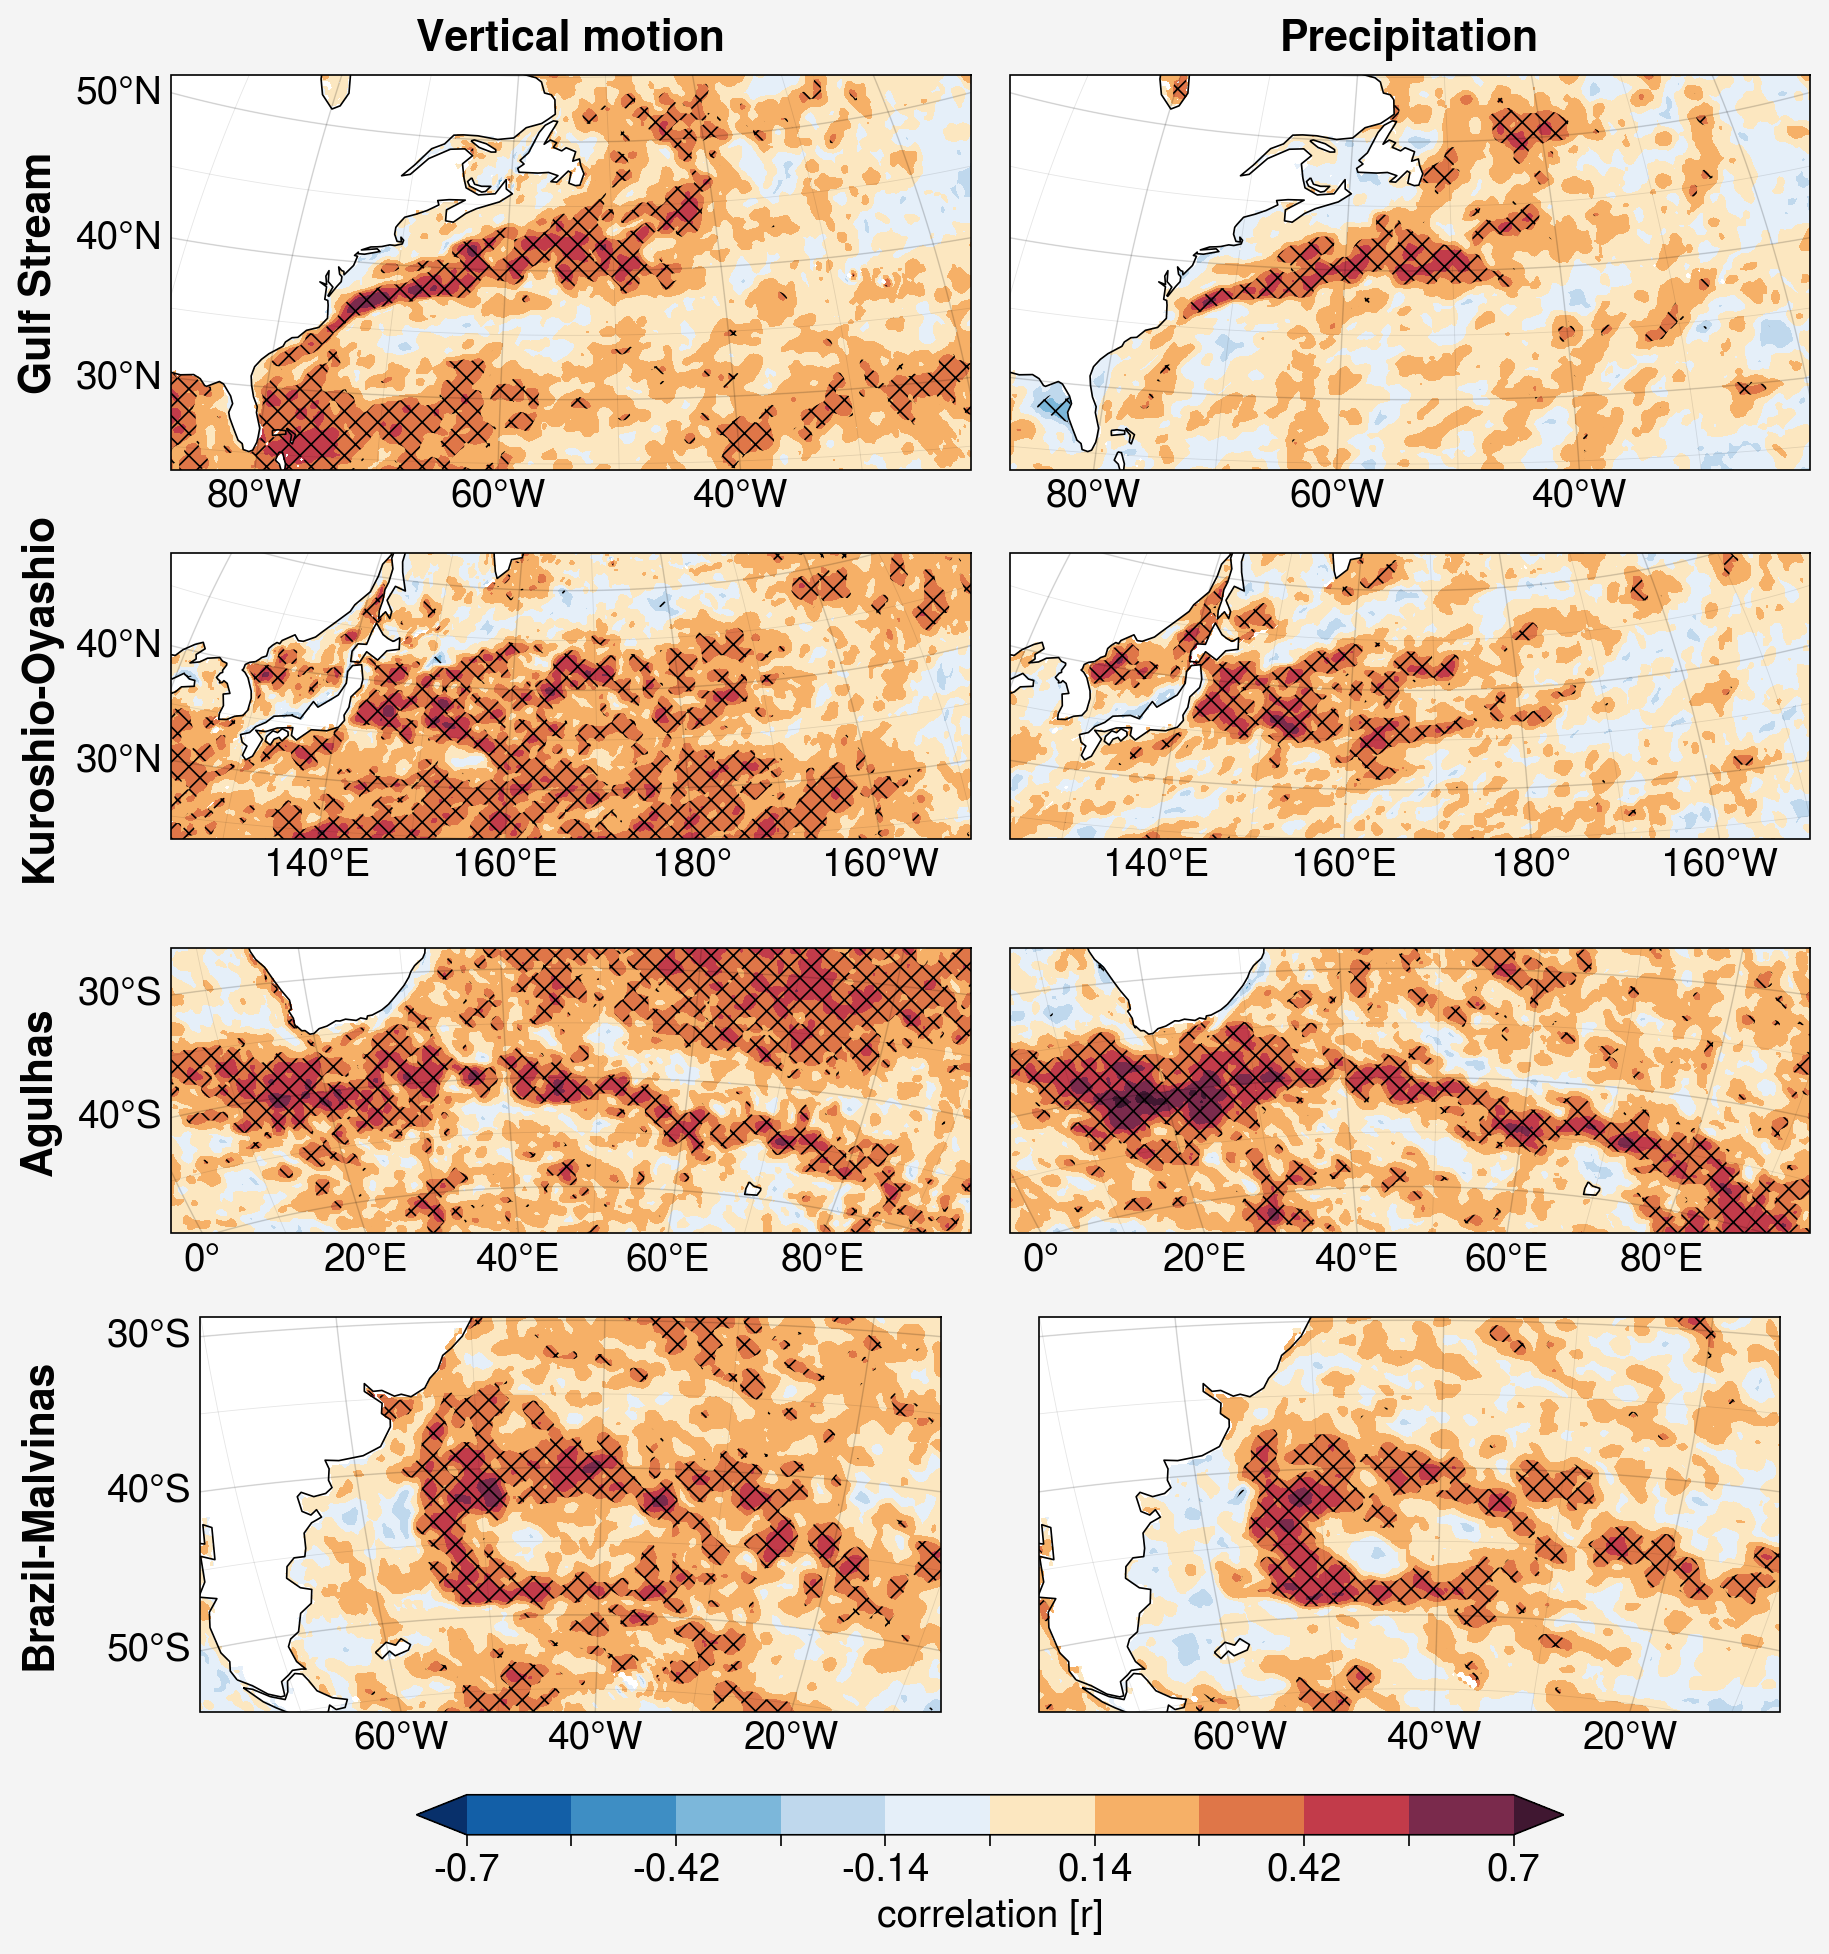

In [34]:
gs = pplt.GridSpec(ncols=2, nrows=4)
fig = pplt.figure(refwidth=4)
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvls = np.linspace(-0.7, 0.7, 11)

for ii, val in enumerate(regionLabels):

    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]


    path = '/glade/work/jamesl/ERA5/'
    SSTE5anom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                                )['SST'].sel(time=dateE,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])
                                             ).load()
    SSTE5anom = SSTE5anom.where(land_mask(SSTE5anom))

    wE5anom = xr.open_dataset(path+'ERA5.h0.w.anomalies.200701-202309.nc'
                              )['w'].sel(time=dateE, level=850,
                                         # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                         lat=slice(region[ii]['lats'], region[ii]['latn'])
                                         ).load()*1000

    prectE5anom = xr.open_dataset(path+'ERA5.h0.PRECT.anomalies.41HPfilter.197901-202309.nc'
                                  )['PRECT'].sel(time=dateE,
                                                 # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                 lat=slice(region[ii]['lats'], region[ii]['latn'])).load()


    wE5anomCorr = wE5anom[0].copy(deep=True)
    prectE5anomCorr = prectE5anom[0].copy(deep=True)

    data  = wE5anom[wE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    wE5anomCorr[:, :] = lag_linregress_3D(data1.values, data.values)[1]

    dof = data.shape[0]  # set dof to 1 per month
    wE5anomTvals = wE5anomCorr*np.sqrt(dof-2)/np.sqrt(1-wE5anomCorr**2)
    tStatUpW = stats.t.ppf(.995, loc=0, scale=1.0, df=dof)

    data  = prectE5anom[prectE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    prectE5anomCorr[:, :] = lag_linregress_3D(data1.values, data.values)[1]

    # Calculate the t statistic
    dof = data.shape[0]  # set dof to 1 per month
    prectE5anomTvals = prectE5anomCorr*np.sqrt(dof-2)/np.sqrt(1-prectE5anomCorr**2)
    tStatUpPrect = stats.t.ppf(.995, loc=0, scale=1.0, df=dof)


    m, ax = plot_it(gs[ii, 0], wE5anomCorr,     lvls, region[ii], cmap=cmap1)
    ax.contourf(np.abs(wE5anomTvals), levels=np.array([-10, tStatUpW, 20]),
                hatches=['', 'xxx'], color=('none', 'none'))

    n, ax = plot_it(gs[ii, 1], prectE5anomCorr, lvls, region[ii], cmap=cmap1, latlabels=False)
    ax.contourf(np.abs(prectE5anomTvals), levels=np.array([-10, tStatUpPrect, 20]),
                hatches=['', 'xxx'], color=('none', 'none'))


fig.format(rowlabels=regionLabels, collabels=['Vertical motion', 'Precipitation'])

tlabels = [str(np.round(val, decimals=3)) for val in lvls]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(m, loc='b', label='correlation [r]', length=0.7, ticklabels=tlabels)

fig.save('corrOfw850_PRECT-stippling99PercentTwoTail96dof-ERA5-LarsonThompsonHurrell2024.png')
fig.save('corrOfw850_PRECT-stippling99PercentTwoTail96dof-ERA5-LarsonThompsonHurrell2024.pdf')



# Suppl Fig: Masks used in the vertical profile

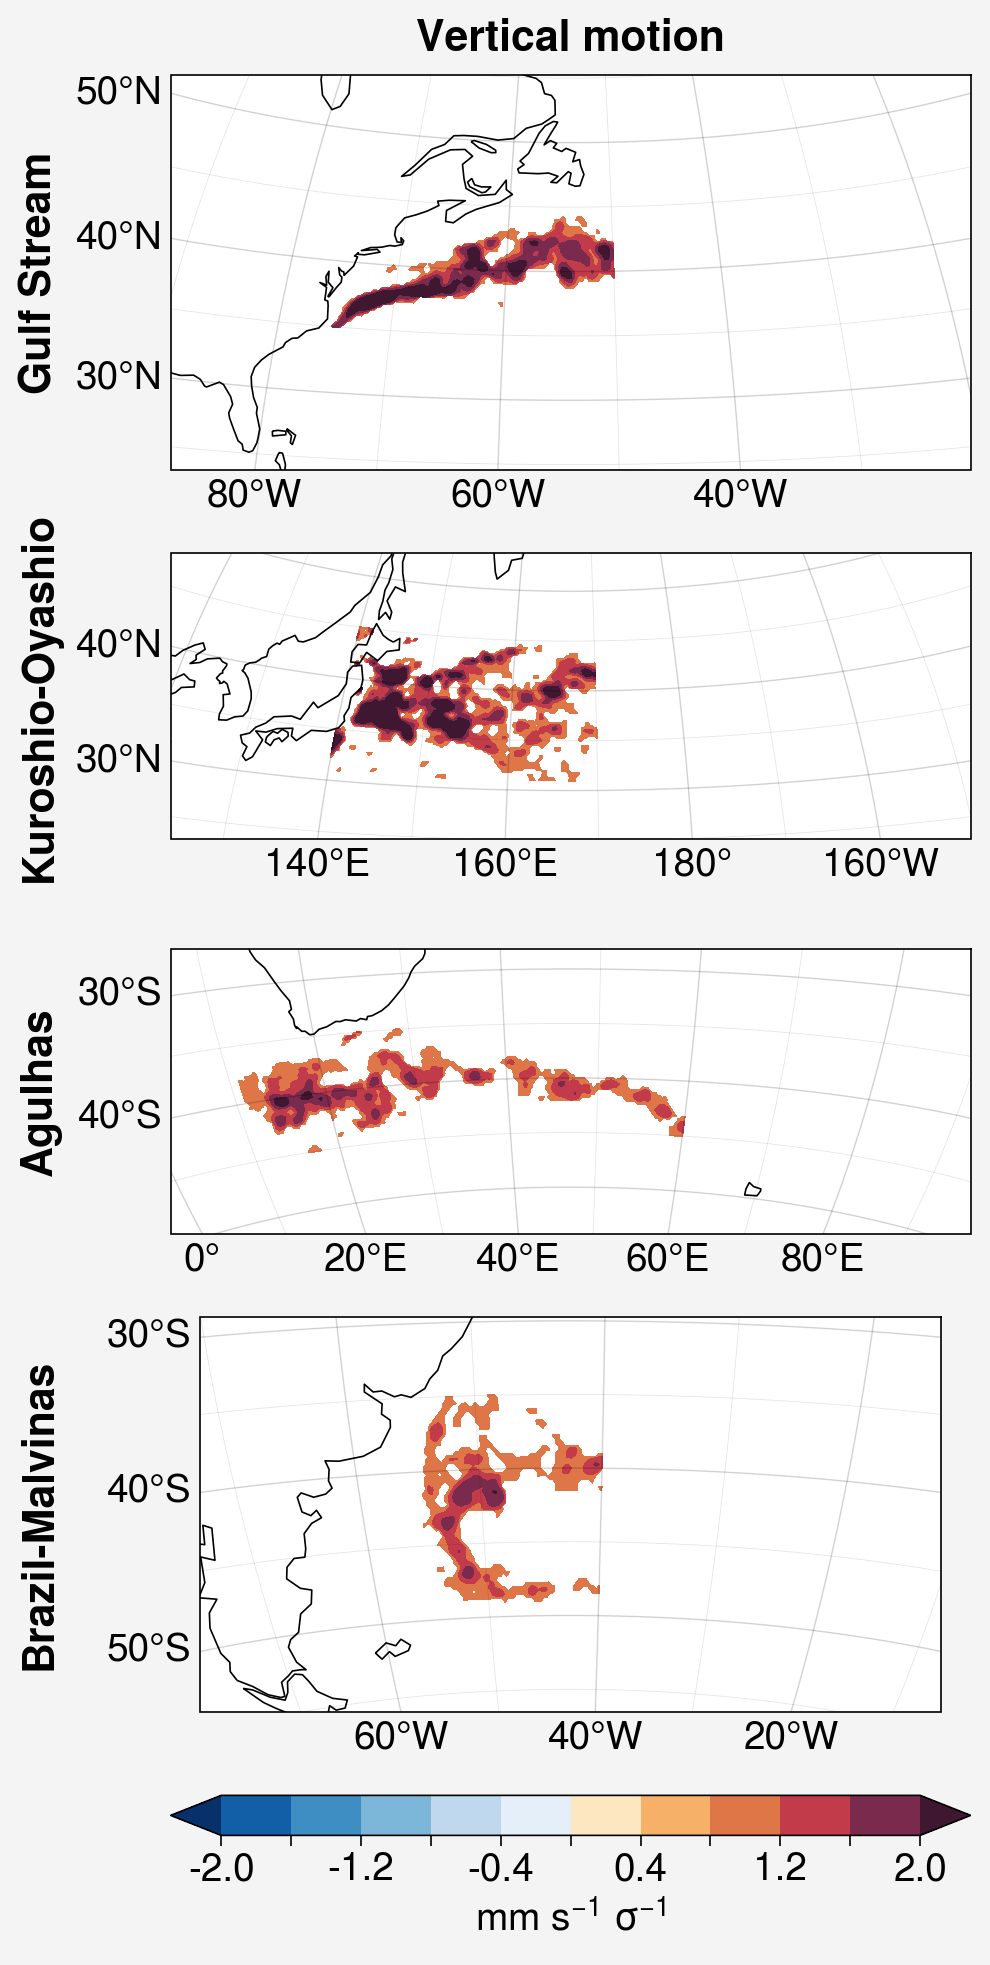

In [46]:
gs = pplt.GridSpec(ncols=1, nrows=4)
fig = pplt.figure(refwidth=4)
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvlsOmega = np.arange(-.02, .021, .004)
lvlsW = np.arange(-2, 2.1, 0.4)

for ii, val in enumerate(regionLabels):
# for ii, val in enumerate([1]):

    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]

    path = '/glade/work/jamesl/ERA5/'
    SSTE5anom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                                )['SST'].sel(time=dateE,
                                             lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                                             lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])
                                             ).load()
    SSTE5anom = SSTE5anom.where(land_mask(SSTE5anom))

    wE5anom = xr.open_dataset(path+'ERA5.h0.w.anomalies.200701-202309.nc'
                              )['w'].sel(time=dateE, level=850,
                                         lon=slice(regionInd[ii]['lonw'], regionInd[ii]['lone']),
                                         lat=slice(regionInd[ii]['lats'], regionInd[ii]['latn'])
                                         ).load()*1000

    wE5anomReg = wE5anom[0].copy(deep=True)

    data  = wE5anom[wE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    wE5anomReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    m, ax = plot_it(gs[ii, 0], wE5anomReg.where(wE5anomReg > 0.8), lvlsW, region[ii], cmap=cmap1)

fig.format(rowlabels=regionLabels, collabels=['Vertical motion'])

tlabels = [str(np.round(val, decimals=3)) for val in lvlsW]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(m, loc='b', label='mm s$^{-1}$ σ$^{-1}$', length=1, ticklabels=tlabels)

fig.save('spatialMasksOfRegressonOfw850-ERA5-LarsonThompsonHurrell2024.png')
fig.save('spatialMasksOfRegressonOfw850-ERA5-LarsonThompsonHurrell2024.pdf')



# Suppl Fig: Comparison of filtered to unfiltered mean PRECT ERA5

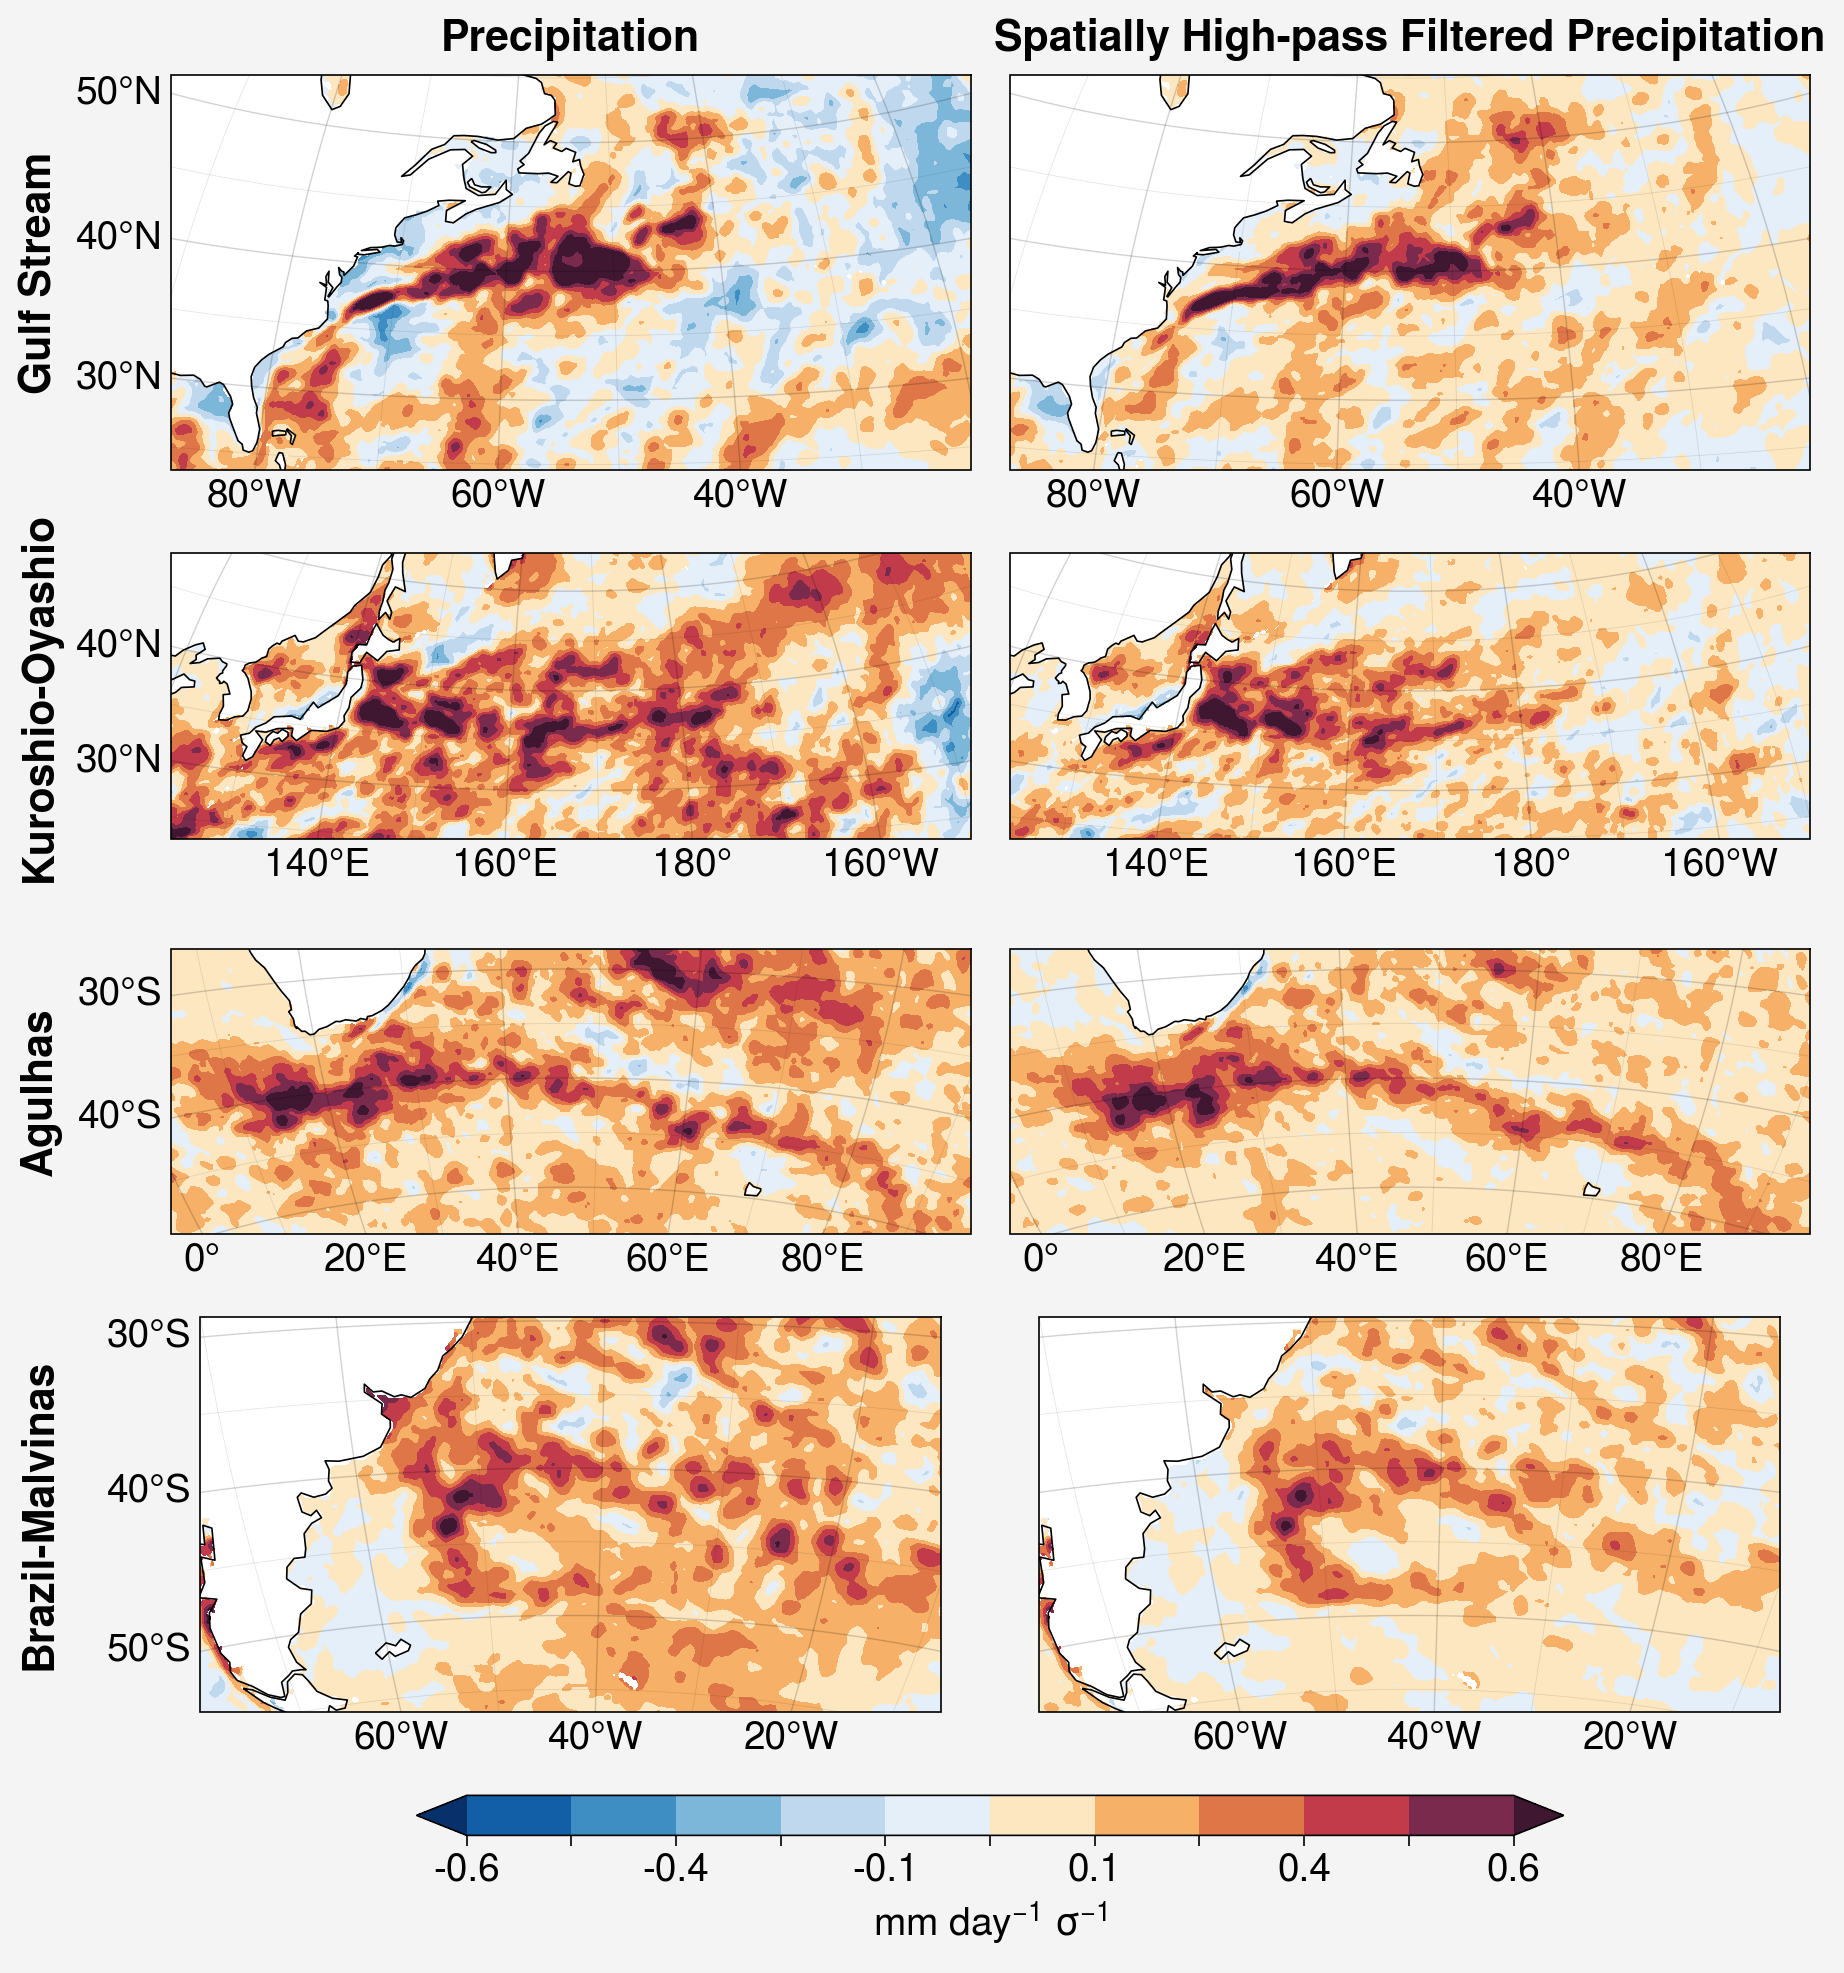

In [19]:
gs = pplt.GridSpec(ncols=2, nrows=4)
fig = pplt.figure(refwidth=4) #, suptitle='Mean fields')
cmap1 = pplt.Colormap('Blues_r', 'fire', name='Diverging')

lvlsPrect = np.arange(-0.625, 0.6251, 0.125)
# lvlsPrectFilt = np.linspace(-2,2,11)

for ii, val in enumerate(regionLabels):

    # Load in the data of interest
    if ii < 2:
        dateE = slice('2007-10', '2023-03')
        months = [10, 11, 12, 1, 2, 3]
    elif ii >= 2:
        dateE = slice('2008-04', '2023-09')
        months = [4, 5, 6, 7, 8, 9]


    path = '/glade/work/jamesl/ERA5/'
    SSTE5anom = xr.open_dataset(path+'ERA5.h0.SST.detrended.anomalies.197901-202309.nc'
                                )['SST'].sel(time=dateE,
                                             # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                             lat=slice(region[ii]['lats'], region[ii]['latn'])
                                             ).load()
    SSTE5anom = SSTE5anom.where(land_mask(SSTE5anom))

    prectE5anom = xr.open_dataset(path+'ERA5.h0.PRECT.anomalies.197901-202309.nc'
                                  )['PRECT'].sel(time=dateE,
                                                 # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                 lat=slice(region[ii]['lats'], region[ii]['latn'])
                                                 ).load()*1000

    prectFiltE5anom = xr.open_dataset(path+'ERA5.h0.PRECT.anomalies.41HPfilter.197901-202309.nc'
                                      )['PRECT'].sel(time=dateE,
                                                     # lon=slice(region[ii]['lonw'], region[ii]['lone']),
                                                     lat=slice(region[ii]['lats'], region[ii]['latn'])).load()

    prectE5anomReg = prectE5anom[0].copy(deep=True)
    prectFiltE5anomReg = prectFiltE5anom[0].copy(deep=True)

    data  = prectE5anom[prectE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    prectE5anomReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    data  = prectFiltE5anom[prectFiltE5anom['time.month'].isin(months)]
    data1 = stand(SSTE5anom[SSTE5anom['time.month'].isin(months)])
    prectFiltE5anomReg[:, :] = lag_linregress_3D(data1.values, data.values)[2]

    m, ax = plot_it(gs[ii, 0], prectE5anomReg,     lvlsPrect, region[ii], cmap=cmap1)
    n, ax = plot_it(gs[ii, 1], prectFiltE5anomReg, lvlsPrect, region[ii], cmap=cmap1, latlabels=False)


fig.format(rowlabels=regionLabels,
           collabels=['Precipitation', 'Spatially High-pass Filtered Precipitation'])

tlabels = [str(np.round(val, decimals=1)) for val in lvlsPrect]
tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
fig.colorbar(n, loc='b', label='mm day$^{-1}$ σ$^{-1}$', length=0.7, ticklabels=tlabels)

# tlabels = [str(np.round(val, decimals=2)) for val in lvlsPrectFilt]
# tlabels = ["" if i % 2 == 1 else elem for i, elem in enumerate(tlabels)]
# fig.colorbar(o, loc='b', label='mm day$^{-1}$', col=2, ticklabels=tlabels)

fig.save('regressionOfPRECT-unfiltVsFilt-ERA5-LarsonThompsonHurrell2024.png')
fig.save('regressionOfPRECT-unfiltVsFilt-ERA5-LarsonThompsonHurrell2024.pdf')
